# Hillslope debris flow runout simulation and analysis


- [Config](#Config)
- [Read General Data](#ReadGeneralData)
- [General Analysis](#GeneralAnalysis)
- [Runout Analysis](#RunoutAnalysis)
- [Sensitivity Analysis](#SensitivityAnalysis)


<a id="Config"></a>
## Config

In [1]:
import os
import glob

import math

import numpy as np
import pandas as pd
import geopandas as gpd

from osgeo import gdal
from osgeo import gdal_array
gdal.UseExceptions()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from matplotlib.cbook import boxplot_stats
from matplotlib.transforms import ScaledTranslation
import matplotlib.ticker as mtick
import seaborn as sns

import itertools 


mkdir -p failed for path /home/jupyter-slc4/.cache/matplotlib: [Errno 13] Permission denied: '/home/jupyter-slc4/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-6apsltv4 because there was an issue with the default path (/home/jupyter-slc4/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
from SALib import ProblemSpec

<a id="ReadGeneralData"></a>
## Read General Data 

Reading hillslope debris flow (HDF) reference data.

In [3]:
input_base_path = "/mnt/kottos_e/GIS_Projekte/Paper_4/data/data_collection"
plot_path = os.path.join(input_base_path,"Dataset_Runout_Merged.gpkg")
input_layer = "inputs_merged"
df_slides = gpd.read_file(plot_path, layer=input_layer, engine="pyogrio", fid_as_index=True )
df_slides = df_slides[df_slides["canton"].isin(["BE","GR"])]
df_slides.reset_index(inplace=True)

in_forest_labels = {0:"Non-forested",1:"Inside forest",2:"Partially inside forest"}
df_slides["HDF location"] = df_slides["in_forest"].apply(lambda x: in_forest_labels[x])


ERROR 1: PROJ: proj_create_from_database: Open of /opt/tljh/user/envs/lab/share/proj failed


In [4]:
df_slides.columns

Index(['fid', 'area_type', 'in_forest', 'STORMENR', 'volume_ori',
       'failure_area_ori', 'thickness_ori', 'area_m2', 'slide_id', 'canton',
       'dbh_mean_cm', 'thickness_m', 'stemdensity_per_ha', 'year',
       'runout_length_m', 'geometry', 'HDF location'],
      dtype='object')

<a id="GeneralAnalysis"></a>
## General Analysis


Number of HDF by canton and location.

In [5]:
df = df_slides[df_slides["area_type"]==1].reset_index()
df = df.groupby(["canton","HDF location"])["fid"].count().reset_index()
df.pivot(index=["canton"],columns=["HDF location"],values=["fid"])

fid             
HDF location Inside forest Non-forested
canton                                 
BE                       9            5
GR                      13           43

In [6]:
df = df_slides[df_slides["area_type"]==1].reset_index()
df = df.groupby(["HDF location"])["fid"].count().reset_index()
df

HDF location  fid
0  Inside forest   22
1   Non-forested   48

In [7]:
df = df_slides[df_slides["area_type"]==1].reset_index()
df = df.groupby(["canton","year"])["fid"].count().reset_index()
df.pivot(index=["canton"],columns=["year"],values=["fid"])

fid                                                    
year   1958 2001  2002 2003  2005 2010 2012 2013 2014 2018 2019
canton                                                         
BE      NaN  1.0   NaN  NaN   8.0  1.0  1.0  1.0  2.0  NaN  NaN
GR      1.0  NaN  32.0  1.0  17.0  1.0  1.0  NaN  NaN  2.0  1.0

In [8]:
# Statistics on runout length
df_slides[df_slides["area_type"]==1]["runout_length_m"].describe()

count     70.000000
mean      80.671429
std       76.617764
min        4.000000
25%       27.250000
50%       59.000000
75%      108.750000
max      433.000000
Name: runout_length_m, dtype: float64

In [9]:
# Statistics on failure area
df_slides[df_slides["area_type"]==1]["area_m2"].describe()

count      70.000000
mean      250.483143
std       456.901170
min        17.104054
25%        53.699819
50%       107.807112
75%       292.112927
max      3608.241055
Name: area_m2, dtype: float64

In [10]:
# Statistics on total area
df_slides.groupby(by=["slide_id"])["area_m2"].sum().describe()

count       70.000000
mean      1339.434739
std       1763.542885
min         49.404585
25%        285.903114
50%        833.060195
75%       1615.681736
max      10977.816950
Name: area_m2, dtype: float64

Looking at the value range for the variable friction inside the forest.

In [11]:
def mu_variable(inputVelocity,dn,slope,g=9.81 ):
    res = (inputVelocity**2)*dn/(2*g*math.cos(math.radians(slope)))
    return res

In [12]:
combs = list(itertools.product([velocity/10 for velocity in range(1,141,2)],[dbh for dbh in range(20,40,5)],[n for n in range(200,500,100)],[slope for slope in range(15,66,10)]))
combs_df = pd.DataFrame(combs,columns=["velocity","dbh","n","slope"])
combs_df["dn"] = combs_df["dbh"]/100*combs_df["n"]/10000
combs_df["mu"] = combs_df.apply(lambda x: mu_variable(inputVelocity=x["velocity"],dn=x["dn"],slope=x["slope"]),axis=1)
combs_df["mu"].describe()


count    5040.000000
mean        0.040672
std         0.044685
min         0.000002
25%         0.006531
50%         0.026187
75%         0.060034
max         0.326220
Name: mu, dtype: float64

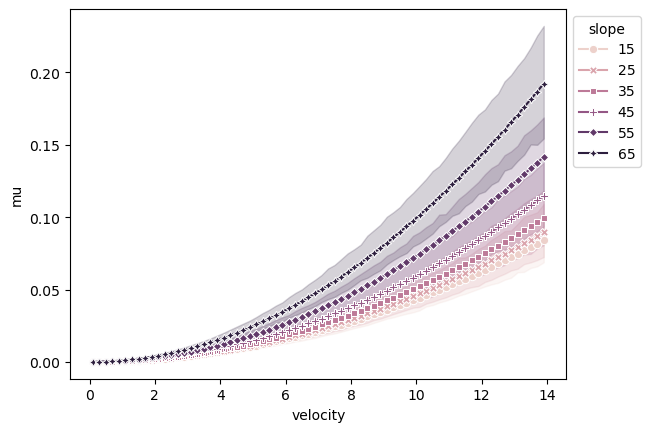

In [13]:
ax = sns.lineplot(
    data=combs_df,
    x="velocity", y="mu", hue="slope", style="slope",
    markers=True, dashes=False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

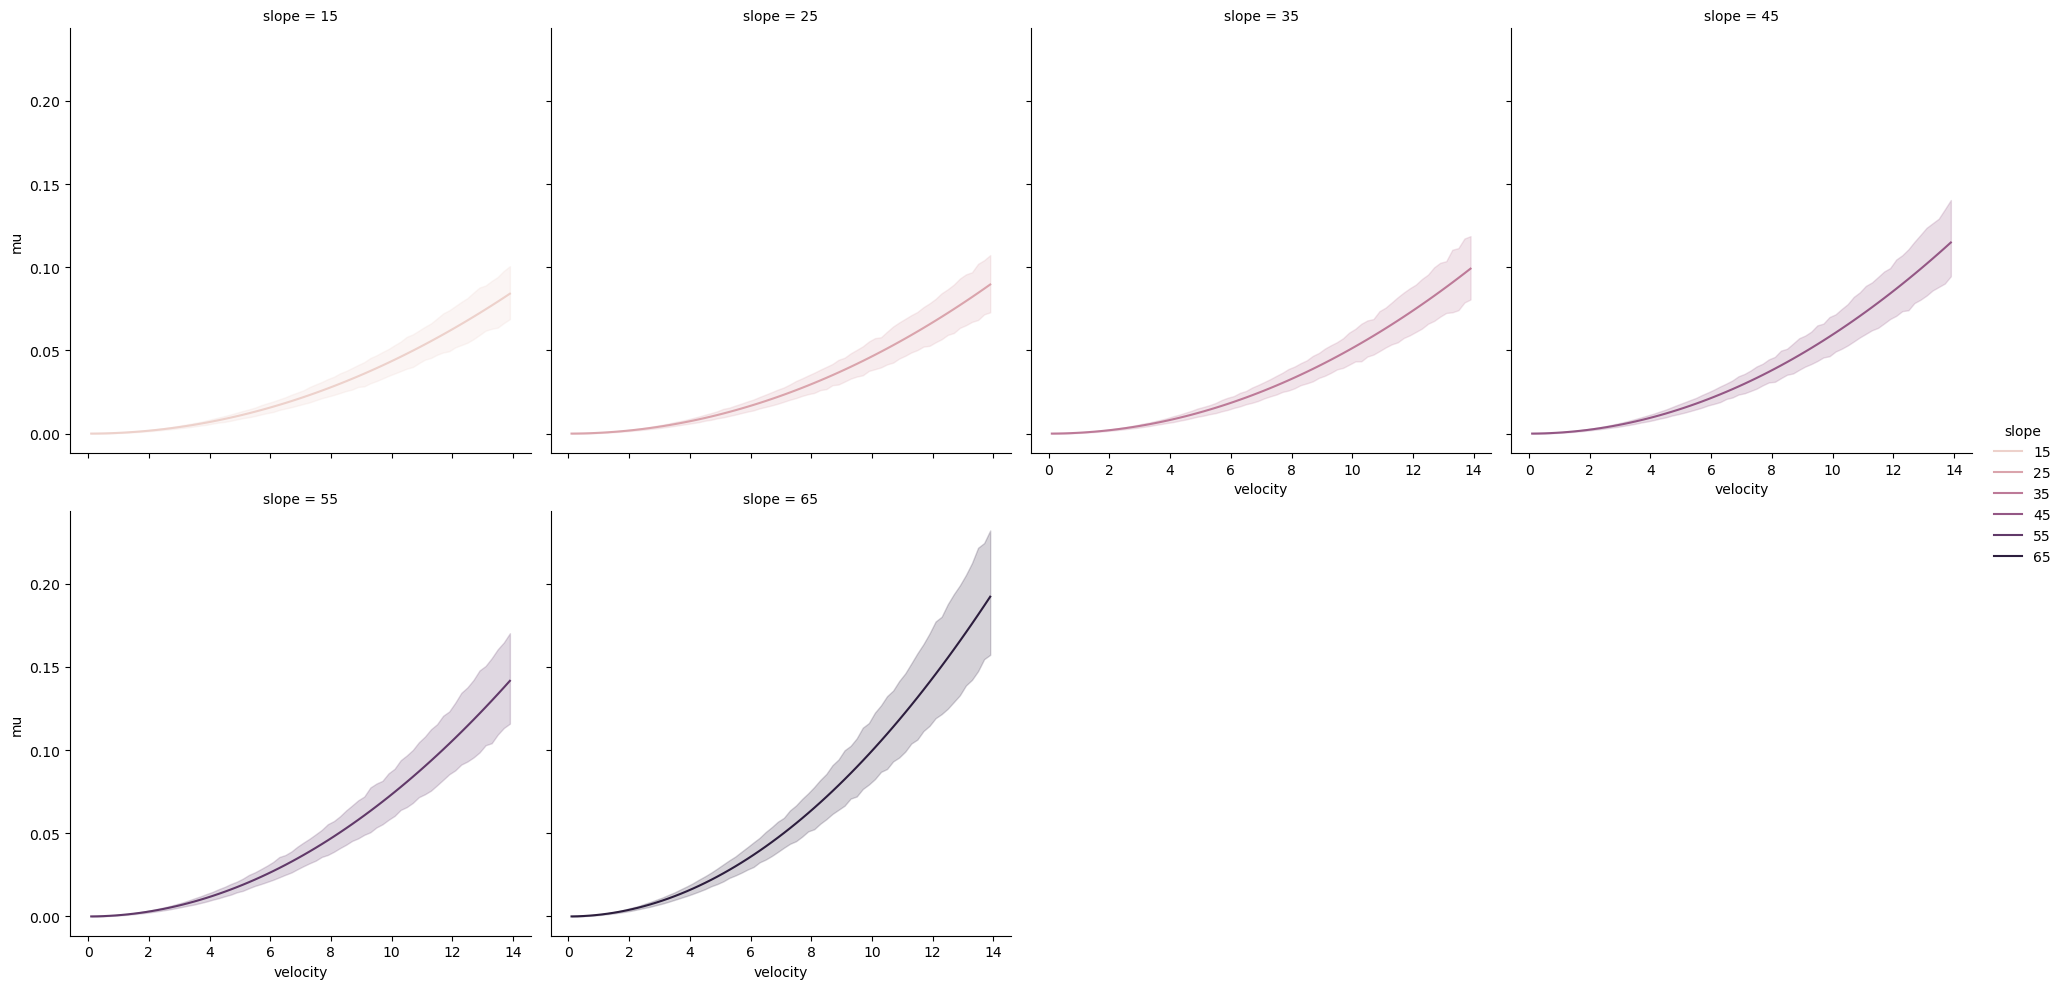

In [14]:
ax = sns.relplot(
    data=combs_df,
    x="velocity", y="mu", hue="slope", 
    markers=True, dashes=False, kind="line",col = "slope", col_wrap=4
)


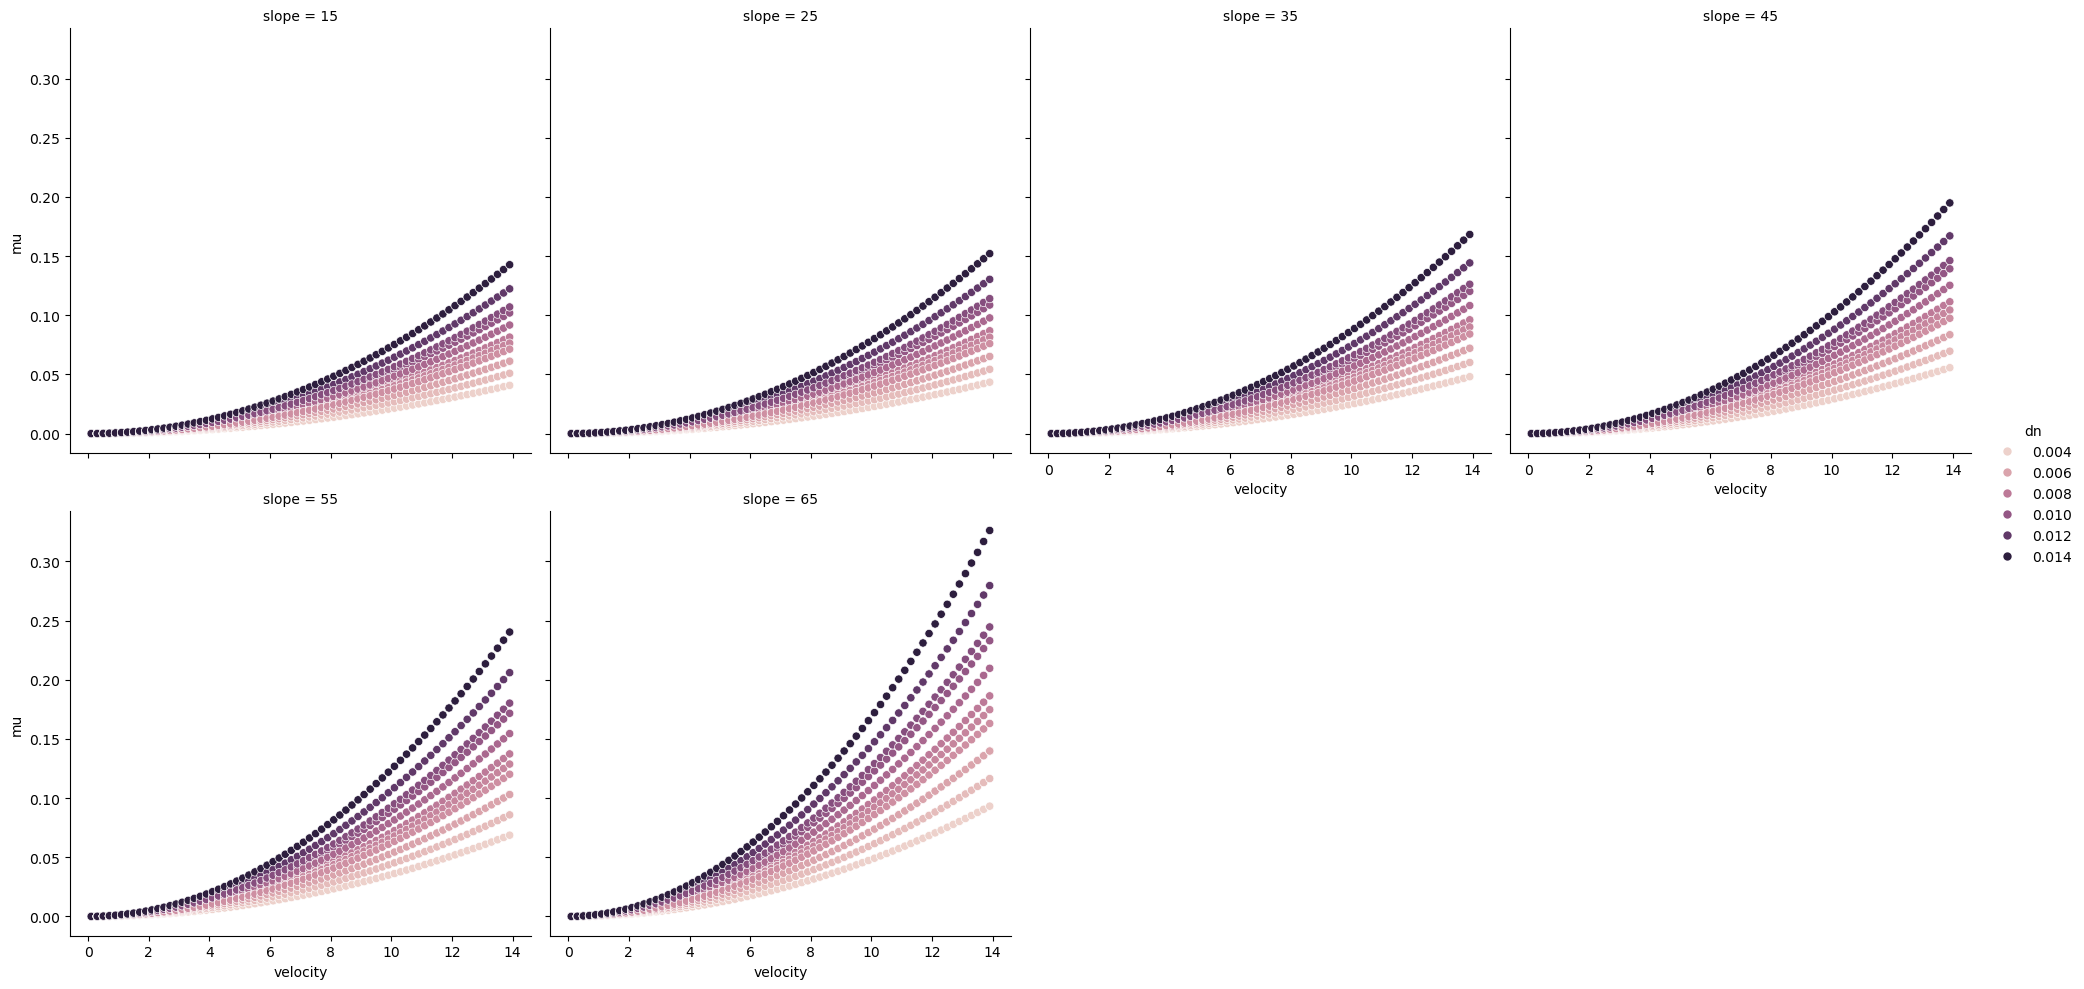

In [15]:
ax = sns.relplot(data=combs_df, x="velocity", y="mu", hue="dn",kind="scatter",col = "slope", col_wrap=4)


<a id="RunoutAnalysis"></a>
## Runout Analysis


### Read Data


In [16]:
# Functions for reading the data generated by the simulation post-processing script

slide_type_labels = {
    0:"1) Loose material/\nhigh water content",
    1:"2) Loose material/\nnormal water content", 
    2:"3) Adhesive material/\nhigh water content",
    3:"4) Adhesive material/\nnormal water content"
}

forest_labels = {
    0:"A) Without forest",
    1:"B) With accumulation",
    2:"D) With accumulation and friction fix",
    3:"C) With accumulation and friction",
    4:"F) With friction fix",
    5:"E) With friction",
}

def read_simstats(combination_path, forest_labels = forest_labels):
    df_stats= pd.read_csv(combination_path)
    join_columns = ["fid",
    "year",
    "failure_area_ori",
    "area_m2",
    "slide_id",
    "canton",
    "in_forest",
    "dbh_mean_cm",
    "thickness_m",
    "stemdensity_per_ha"]
    # Only select the failure/start polygons to avoid duplication
    df_slides_start = df_slides[df_slides["area_type"]==1][join_columns]

    # Join reference data to result data
    df_sim = pd.merge(df_stats, df_slides_start, how="left", on="slide_id", suffixes=('_x', '_y'))

    # Add a copy of all data with the location/group "All"
    df_sim_sel = df_sim.reset_index(drop=True)
    df_sim_sel["in_forest"] = -1
    df_sim = pd.concat([df_sim,df_sim_sel]) 
    
    # Add labels for codes
    df_sim["slide_type_label"] = df_sim["slide_type"].apply(lambda x: slide_type_labels[x])
    df_sim["forest_label"] = df_sim["forest"].apply(lambda x: forest_labels[x])
    df_sim["in_forest_label"] = df_sim["in_forest"].apply(lambda x: "Non-forested" if x==0 else ("Forested" if x>0 else "All"))

    # (Re)-calculate the performance measures
    df_sim["ppv"] = df_sim["tp"] / (df_sim["tp"]+df_sim["fp"])
    df_sim["npv"] = df_sim["tn"] / (df_sim["tn"]+df_sim["fn"])
    df_sim["tpr"] = df_sim["tp"] / (df_sim["tp"]+df_sim["fn"])
    df_sim["fpr"] = df_sim["fp"] / (df_sim["fp"]+df_sim["tn"])
    df_sim["csi"] = df_sim["tp"] / (df_sim["tp"]+df_sim["fn"]+df_sim["fp"])
    df_sim["tnr"] = df_sim["tn"] / (df_sim["tn"]+df_sim["fp"])
    df_sim["acc"] = (df_sim["tp"] + df_sim["tn"]) / (df_sim["tp"]+df_sim["fp"]+df_sim["fn"]+df_sim["tn"])
    df_sim["for"] = df_sim["fn"] / (df_sim["tn"]+df_sim["fn"])
    df_sim["fdr"] = df_sim["fp"] / (df_sim["tp"]+df_sim["fp"])
    df_sim["rj"] = np.sqrt((1-df_sim["tpr"])**2+df_sim["fpr"]**2)

    # Rename columns to facilitate visualization (less manual changes of labelling needed)
    df_sim.rename(columns={"in_forest_label":"HDF location", 
                           "forest_label":"Paramter combination", 
                           "slide_type_label":"HDF type",
                           "slide_id":"HDF ID",
                           "auc":"AUC",
                           "ppv":"PPV",
                           "npv":"NPV",
                           "tpr":"TPR",
                           "fpr":"FPR",
                           "csi":"CSI",
                           "tnr":"TNR",
                           "acc":"ACC",
                           "for":"FOR",
                           "fdr":"FDR",
                          }, inplace=True)
    
    
    return df_sim
    


In [17]:
# Read 100th percentile
df_sim_combined = read_simstats(os.path.join(input_base_path,"simulation_inputs","sim_stats_0.csv"))
df_sim_combined["Percentile"] = 100
len(df_sim_combined)

3360

In [18]:
# Read 90th percentile
df_sim_combined_90 = read_simstats(os.path.join(input_base_path,"simulation_inputs","sim_stats_10.csv"))
df_sim_combined_90["Percentile"] = 90
len(df_sim_combined_90)

3360

In [19]:
# Read 75th percentile
df_sim_combined_75 = read_simstats(os.path.join(input_base_path,"simulation_inputs","sim_stats_25.csv"))
df_sim_combined_75["Percentile"] = 75
len(df_sim_combined_75)

3360

In [20]:
# Merge input data
df_sim_combined_merged = pd.concat([df_sim_combined,df_sim_combined_90,df_sim_combined_75])

In [21]:
df_sim_combined_merged.columns

Index(['HDF ID', 'slide_type', 'forest', 'n', 'n_slide', 'n_runout', 'tp',
       'tn', 'fp', 'fn', 'AUC', 'auc_prob', 'fid', 'year', 'failure_area_ori',
       'area_m2', 'canton', 'in_forest', 'dbh_mean_cm', 'thickness_m',
       'stemdensity_per_ha', 'HDF type', 'Paramter combination',
       'HDF location', 'PPV', 'NPV', 'TPR', 'FPR', 'CSI', 'TNR', 'ACC', 'FOR',
       'FDR', 'rj', 'Percentile'],
      dtype='object')

### Analysis All Percentiles


Performance metrics for all percentiles, parameter combinations, and HDF types  (supplementary material).

In [22]:
df = df_sim_combined_merged[(df_sim_combined_merged["in_forest"]>=0) & df_sim_combined_merged["forest"].isin([0,1,3])].reset_index()
df["HDF type"] = df["HDF type"].apply(lambda x: x.replace("/\n","/"))
sim_agg = df.groupby(by=["HDF type","Paramter combination","Percentile"]).agg(
    {"ACC":["count","mean"],"TPR":["mean"],"TNR":["mean"],"PPV":["mean"]}
)


with pd.option_context("display.max_rows", 200, "display.max_columns", 25, "display.float_format", "{:.1%}".format):
    display(sim_agg)

print(sim_agg.to_latex(bold_rows=True,float_format="{:,.1%}".format))


ACC  \
                                                                                       count   
HDF type                                  Paramter combination              Percentile         
1) Loose material/high water content      A) Without forest                 75            70   
                                                                            90            70   
                                                                            100           70   
                                          B) With accumulation              75            70   
                                                                            90            70   
                                                                            100           70   
                                          C) With accumulation and friction 75            70   
                                                                            90            70   
                                                                            100           70   
2) Loose material/normal water content    A) Without forest                 75            70   
                                                                            90            70   
                                                                            100           70   
                                          B) With accumulation              75            70   
                                                                            90            70   
                                                                            100           70   
                                          C) With accumulation and friction 75            70   
                                                                            90            70   
                                                                            100           70   
3) Adhesive material/high water content   A) Without forest                 75            70   
                                                                            90            70   
                                                                            100           70   
                                          B) With accumulation              75            70   
                                                                            90            70   
                                                                            100           70   
                                          C) With accumulation and friction 75            70   
                                                                            90            70   
                                                                            100           70   
4) Adhesive material/normal water content A) Without forest                 75            70   
                                                                            90            70   
                                                                            100           70   
                                          B) With accumulation              75            70   
                                                                            90            70   
                                                                            100           70   
                                          C) With accumulation and friction 75            70   
                                                                            90            70   
                                                                            100           70   

                                                                                              \
                                                                                        mean   
HDF type                                  Paramter combination              Percentile         
1) Loose material/high water content      A) Without for

\begin{tabular}{lllrrrrr}
\toprule
 &  &  & \multicolumn{2}{r}{ACC} & TPR & TNR & PPV \\
 &  &  & count & mean & mean & mean & mean \\
HDF type & Paramter combination & Percentile &  &  &  &  &  \\
\midrule
\multirow[t]{9}{*}{\textbf{1) Loose material/high water content}} & \multirow[t]{3}{*}{\textbf{A) Without forest}} & \textbf{75} & 70 & 65.6% & 90.5% & 65.0% & 32.6% \\
\textbf{} & \textbf{} & \textbf{90} & 70 & 53.2% & 97.0% & 49.9% & 17.1% \\
\textbf{} & \textbf{} & \textbf{100} & 70 & 36.7% & 99.5% & 33.6% & 7.5% \\
\cline{2-8}
\textbf{} & \multirow[t]{3}{*}{\textbf{B) With accumulation}} & \textbf{75} & 70 & 65.6% & 90.3% & 65.1% & 32.7% \\
\textbf{} & \textbf{} & \textbf{90} & 70 & 53.5% & 96.9% & 50.2% & 17.2% \\
\textbf{} & \textbf{} & \textbf{100} & 70 & 37.1% & 99.4% & 34.0% & 7.6% \\
\cline{2-8}
\textbf{} & \multirow[t]{3}{*}{\textbf{C) With accumulation and friction}} & \textbf{75} & 70 & 65.6% & 90.3% & 65.1% & 32.7% \\
\textbf{} & \textbf{} & \textbf{90} & 70 & 53.5% & 

In [23]:
sim_agg = df_sim_combined_merged[(df_sim_combined_merged["in_forest"]>=0) & df_sim_combined_merged["forest"].isin([0,])].groupby(by=["HDF type","Paramter combination","Percentile"]).agg(
    {"ACC":["count","mean"],"TPR":["mean"],"TNR":["mean"],"PPV":["mean"]}
)

with pd.option_context("display.max_rows", 200, "display.max_columns", 25, "display.float_format", "{:.1%}".format):
    display(sim_agg)

# print(sim_agg.to_latex(bold_rows=True,float_format="{:,.1%}".format))


ACC  \
                                                                            count   
HDF type                                    Paramter combination Percentile         
1) Loose material/\nhigh water content      A) Without forest    75            70   
                                                                 90            70   
                                                                 100           70   
2) Loose material/\nnormal water content    A) Without forest    75            70   
                                                                 90            70   
                                                                 100           70   
3) Adhesive material/\nhigh water content   A) Without forest    75            70   
                                                                 90            70   
                                                                 100           70   
4) Adhesive material/\nnormal water content A) Without forest    75            70   
                                                                 90            70   
                                                                 100           70   

                                                                                   \
                                                                             mean   
HDF type                                    Paramter combination Percentile         
1) Loose material/\nhigh water content      A) Without forest    75         65.6%   
                                                                 90         53.2%   
                                                                 100        36.7%   
2) Loose material/\nnormal water content    A) Without forest    75         77.0%   
                                                                 90         85.0%   
                                                                 100        89.7%   
3) Adhesive material/\nhigh water content   A) Without forest    75         62.5%   
                                                                 90         61.7%   
                                                                 100        69.4%   
4) Adhesive material/\nnormal water content A) Without forest    75         76.3%   
                                                                 90         84.1%   
                                                                 100        89.6%   

                                                                              TPR  \
                                                                             mean   
HDF type                                    Paramter combination Percentile         
1) Loose material/\nhigh water content      A) Without forest    75         90.5%   
                                                                 90         97.0%   
                                                                 100        99.5%   
2) Loose material/\nnormal water content    A) Without forest    75         88.0%   
                                                                 90         89.7%   
                                                                 100        91.5%   
3) Adhesive material/\nhigh water content   A) Without forest    75         91.0%   
                                                                 90         94.7%   
                                                                 100        96.1%   
4) Adhesive material/\nnormal water content A) Without forest    75         88.8%   
                                                                 90         90.6%   
                                                                 100        91.5%   

                                                                              TNR  \
                                                                             mean   
HDF type                                    Paramter combination Percentile     

Performance metrics by percentile for simulations without forest effect.

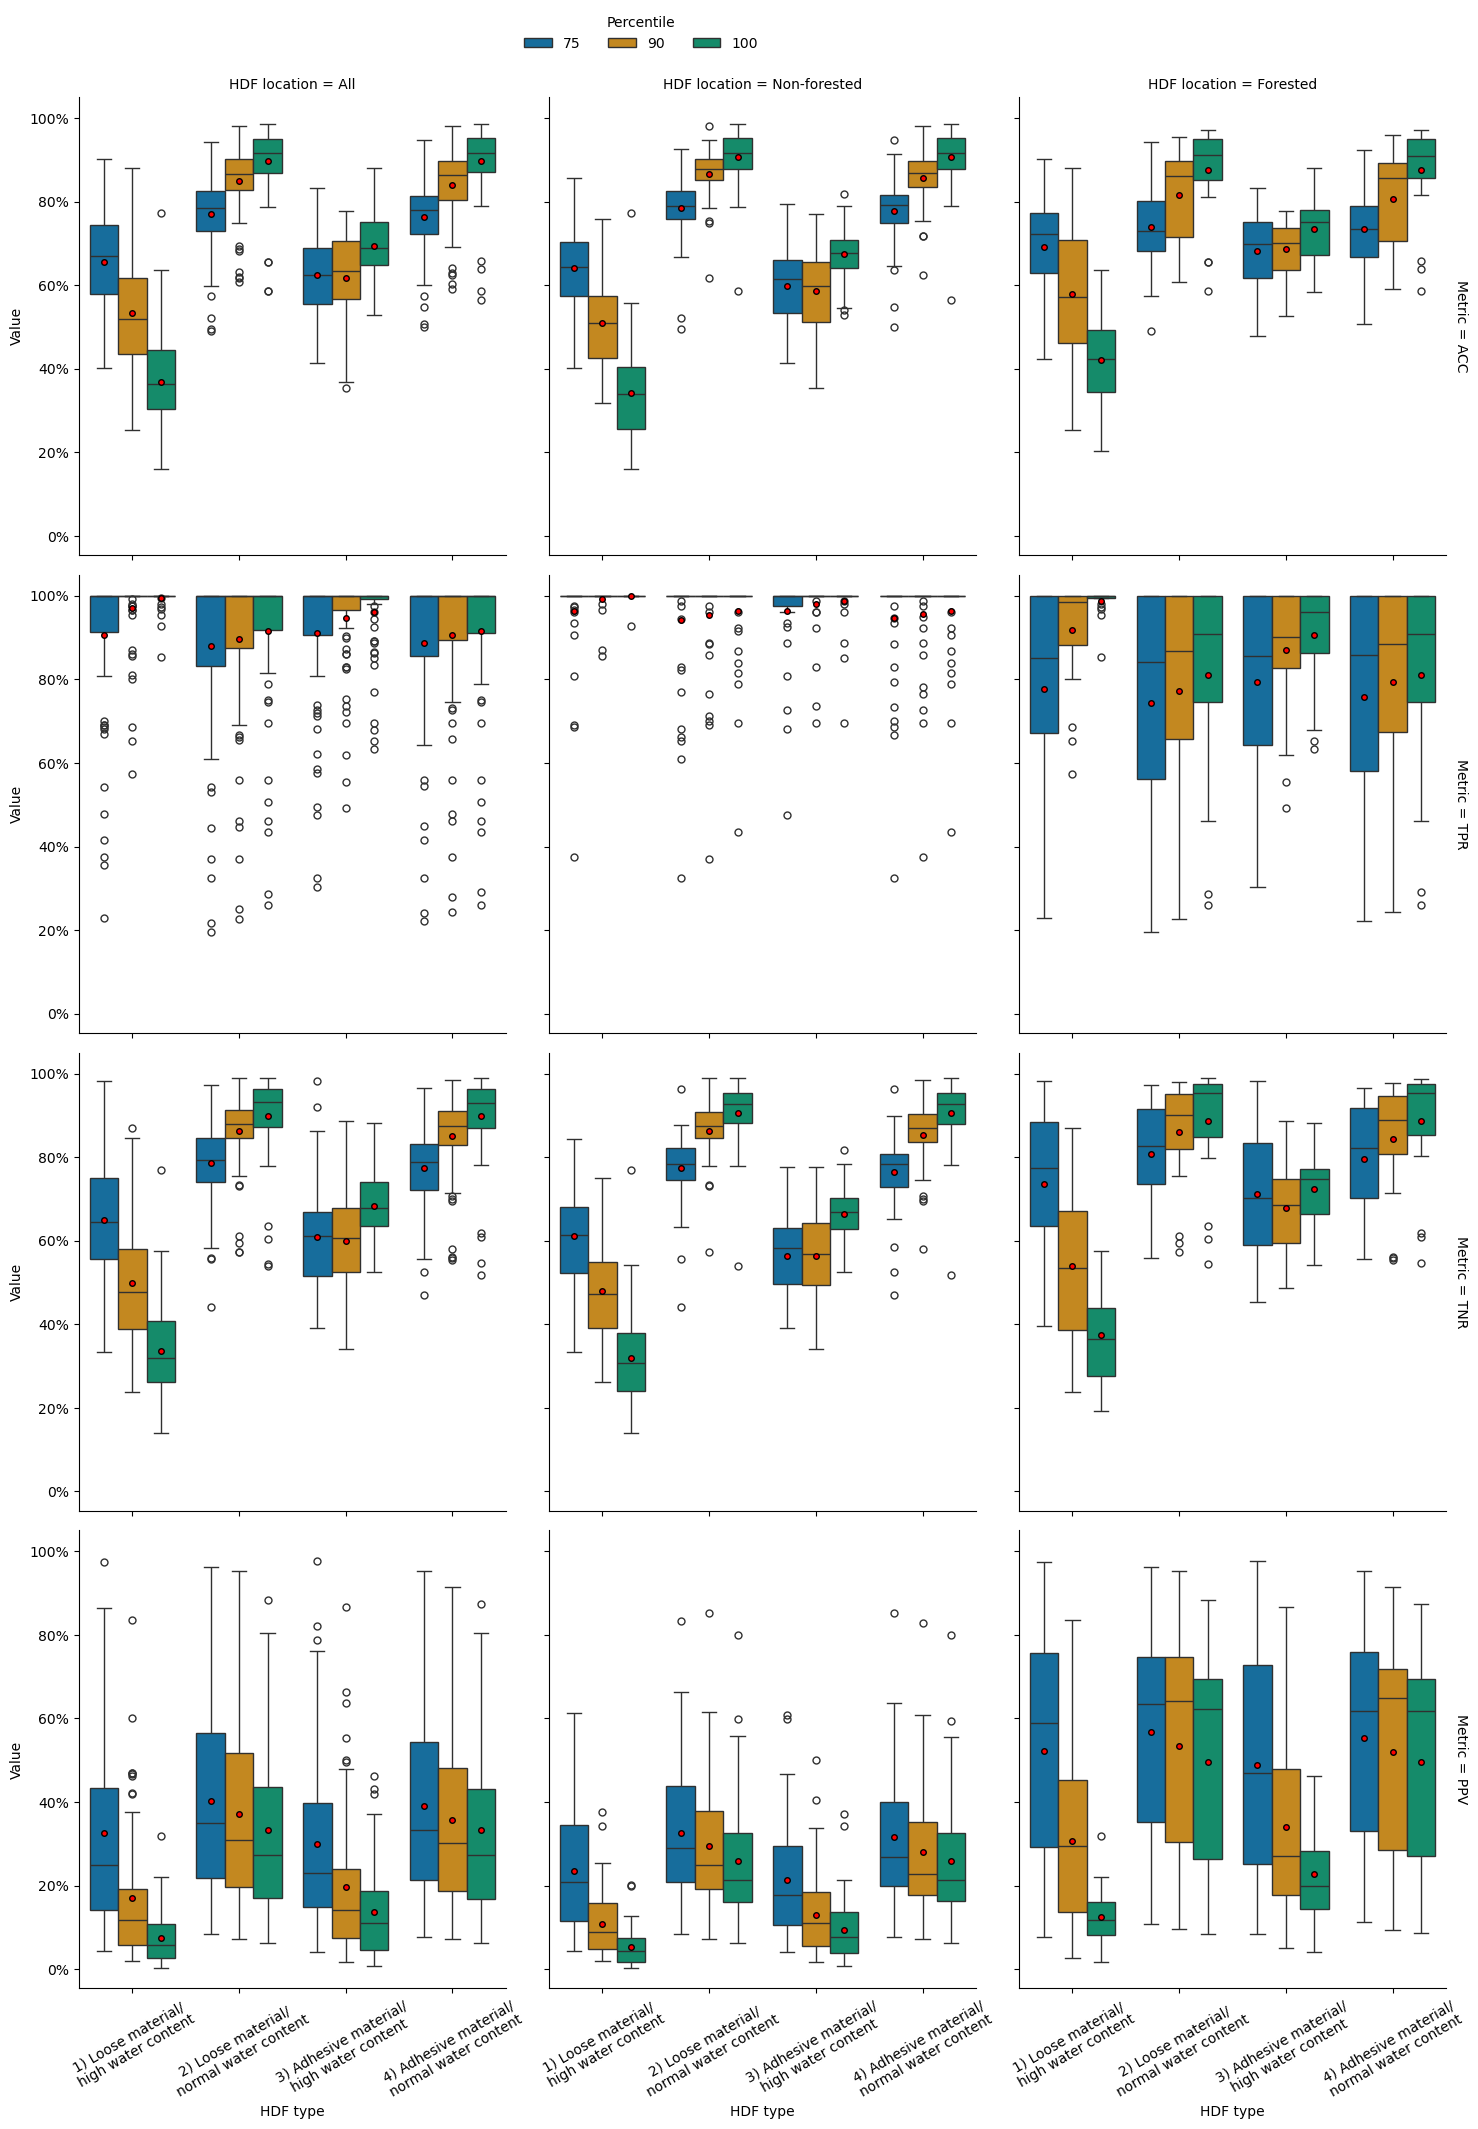

In [24]:
metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df_melt = pd.melt(df_sim_combined_merged[ df_sim_combined_merged["forest"].isin([0,])], id_vars=["HDF type","slide_type","HDF ID","Paramter combination","in_forest","HDF location","Percentile"], value_vars=["TPR","TNR","ACC","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])

df_melt.rename(columns={"value":"Value"}, inplace=True)


df_melt = df_melt.sort_values(by=["in_forest","metric_order"])
fig = sns.catplot(data=df_melt, x="HDF type", y="Value",hue="Percentile",  kind="box", row="Metric", col="HDF location", sharex=True,sharey=True, showfliers = True,palette=sns.color_palette("colorblind",3), margin_titles=True, legend=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'} )

fig.tick_params(axis='x', which='both', rotation=30)

for ax in fig.axes.flatten():
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.4, 1), 
    ncol=6, frameon=False,
)


Performance metrics by paramter combination.

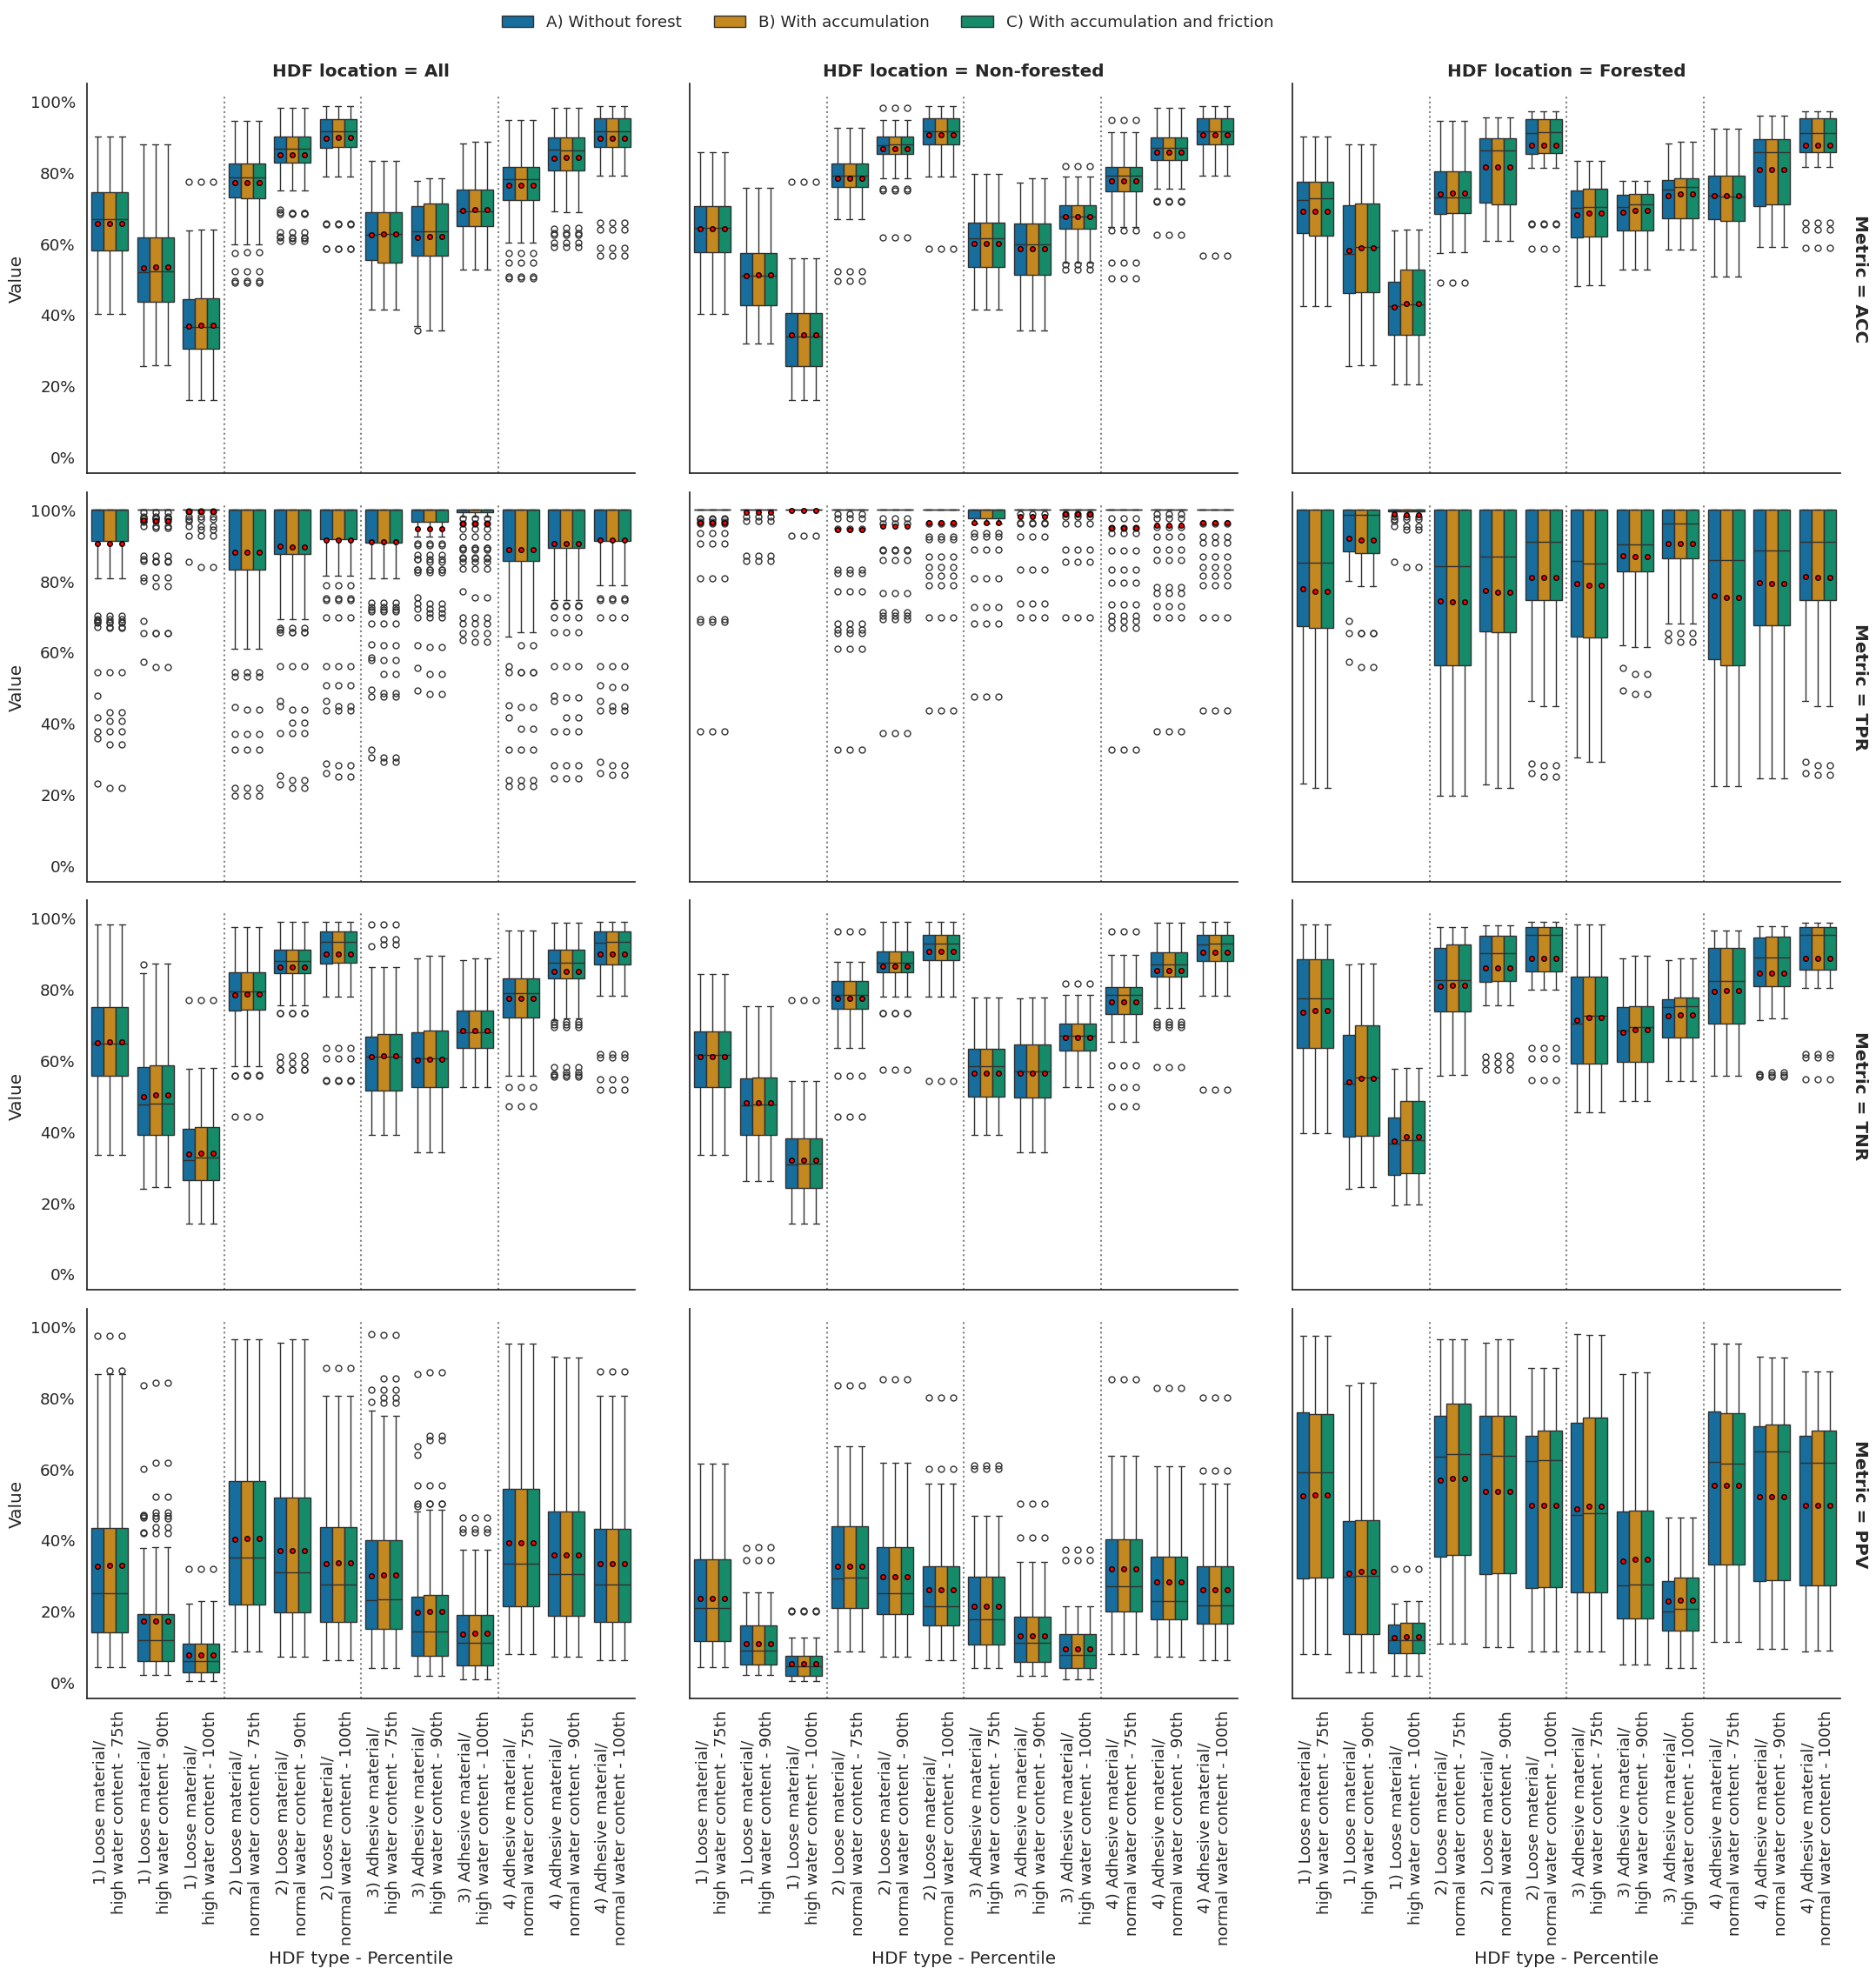

In [25]:
metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df = df_sim_combined_merged[ df_sim_combined_merged["forest"].isin([0,1,3])].reset_index(drop=True)
df["HDF type - Percentile"] = df.apply(lambda x: "{0} - {1}th".format(x["HDF type"],x["Percentile"]),axis=1)

df_melt = pd.melt(df, id_vars=["HDF type","slide_type","HDF ID","Paramter combination","in_forest","HDF location","Percentile","HDF type - Percentile"], value_vars=["TPR","TNR","ACC","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])

df_melt.rename(columns={"value":"Value"}, inplace=True)

sns.set(font_scale=1.2)
sns.set_style("white")

df_melt = df_melt.sort_values(by=["slide_type", "Percentile", "in_forest","metric_order"])
fig = sns.catplot(data=df_melt, x="HDF type - Percentile", y="Value",hue="Paramter combination",  kind="box", row="Metric", col="HDF location", sharex=True,sharey=True, showfliers = True,palette=sns.color_palette("colorblind",3), margin_titles=True, legend=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'}
                 ,height=5, aspect = 1.5)

plt.subplots_adjust(wspace=0.1)

fig.tick_params(axis='x', which='both', rotation=90)

n = len(df_sim_combined_merged["Percentile"].unique())

for ax in fig.axes.flatten():
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    # ax.axvline(x=2.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')
    # ax.axvline(x=5.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')
    # ax.axvline(x=8.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')

    ax.axvline(x=n*1-0.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')
    ax.axvline(x=n*2-0.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')
    ax.axvline(x=n*3-0.5, ymin=0.0, ymax=0.97, color='gray', linestyle=':')
    # ax.axhline(y=1.01, color='gray', linestyle=':')

fig.set_titles(template = "", col_template = "HDF location = {col_name}", row_template = "Metric = {row_name}",weight='bold')

sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.4, 1), 
    ncol=6,  frameon=False,
    title = "",
)

# fig.savefig("fig07.png", dpi=600) 
# fig.savefig("fig07.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
# fig.savefig("fig07.eps", dpi=600)


Looking at the quantile distribution of the performance metrics.

In [26]:
# Preparing the data
metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df = df_sim_combined_merged[ df_sim_combined_merged["forest"].isin([0,1,3]) & (df_sim_combined_merged["in_forest"]>=0)].reset_index(drop=True)
df["HDF type - Percentile"] = df.apply(lambda x: "{0} - {1}th".format(x["HDF type"],x["Percentile"]),axis=1)

df_melt = pd.melt(df, id_vars=["HDF type","slide_type","HDF ID","Paramter combination","in_forest","HDF location","Percentile","HDF type - Percentile"], value_vars=["TPR","TNR","ACC","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])

df_melt.rename(columns={"value":"Value"}, inplace=True)

df_melt_grouped = df_melt.groupby(by=["HDF type", "Paramter combination","Percentile", "Metric"])

df_melt["cum_count"] = df_melt_grouped["Value"].cumcount() 

df_melt = df_melt.sort_values(by=["cum_count"])

df_melt["HDF type"] = df_melt["HDF type"].apply(lambda x: x.replace("\n"," "))

df_mlt_quant = pd.DataFrame(df_melt.groupby(by=["HDF type", "Paramter combination","Percentile", "Metric"])[["Value","cum_count"]].quantile(q=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0], interpolation="nearest")).reset_index()

df_mlt_quant.rename(columns={"level_4":"Quantile"}, inplace=True)

df_mlt_quant = df_mlt_quant.sort_values(by=["Metric","Percentile"])


In [27]:
# Output as pivot table
pvt = df_mlt_quant.pivot_table(index=["HDF type", "Paramter combination","Quantile"], columns=["Metric","Percentile",],values=["Value","cum_count"],sort=False)

with pd.option_context("display.max_rows", 1000, "display.max_columns", 40,"display.precision", 3):
    display(pvt)


Value  \
Metric                                                                                   ACC   
Percentile                                                                               75    
HDF type                                   Paramter combination              Quantile          
1) Loose material/ high water content      A) Without forest                 0.10      0.494   
                                                                             0.20      0.548   
                                                                             0.25      0.578   
                                                                             0.30      0.604   
                                                                             0.40      0.630   
                                                                             0.50      0.669   
                                                                             0.60      0.688   
                                                                             0.70      0.708   
                                                                             0.75      0.745   
                                                                             0.80      0.760   
                                                                             0.90      0.811   
                                                                             1.00      0.902   
                                           B) With accumulation              0.10      0.494   
                                                                             0.20      0.548   
                                                                             0.25      0.578   
                                                                             0.30      0.604   
                                                                             0.40      0.630   
                                                                             0.50      0.669   
                                                                             0.60      0.688   
                                                                             0.70      0.712   
                                                                             0.75      0.745   
                                                                             0.80      0.764   
                                                                             0.90      0.812   
                                                                             1.00      0.902   
                                           C) With accumulation and friction 0.10      0.494   
                                                                             0.20      0.548   
                                                                             0.25      0.578   
                                                                             0.30      0.604   
                                                                             0.40      0.630   
                                                                             0.50      0.669   
                                                                             0.60      0.688   
                                                                             0.70      0.712   
                                                                             0.75      0.745   
                                                                             0.80      0.764   
                                                                             0.90      0.812   
                                                                             1.00      0.902   
2) Loose material/ normal water content    A) Without forest                 0.10      0.668   
                                                                             0.20      0.713   
                                                       

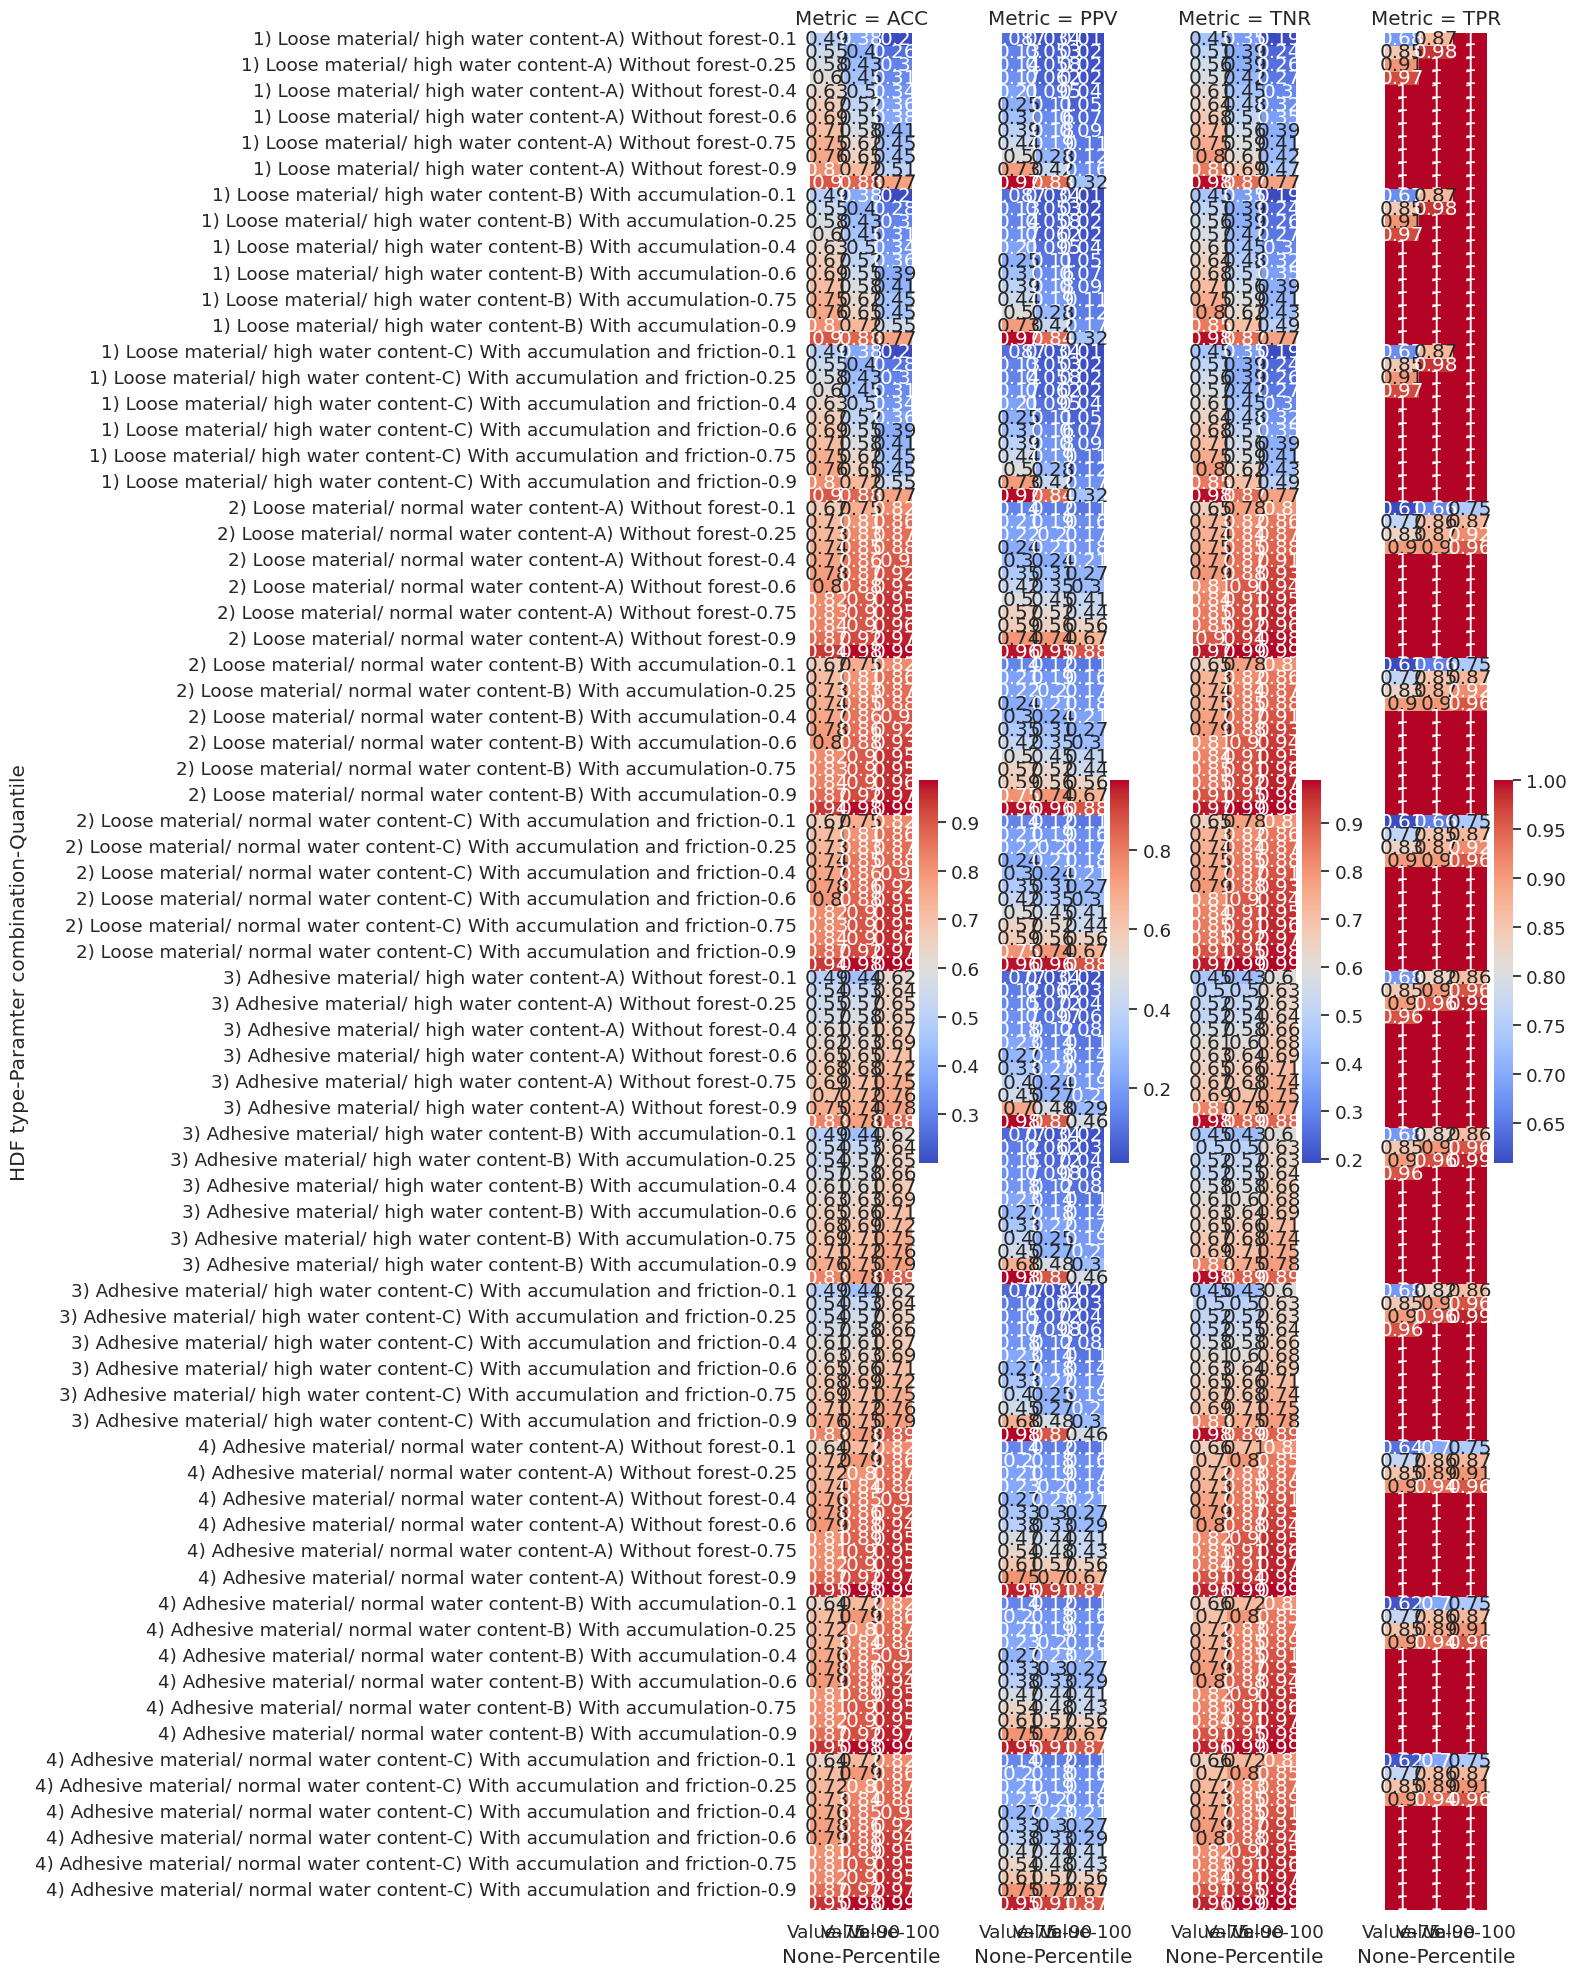

In [28]:
# Output of metric values as heatmaps
df = df_mlt_quant

g = sns.FacetGrid(df, col="Metric", height=20, aspect= 0.2/1)

def draw_heatmap(data, **kwargs):
    pvt = data.pivot_table(index=["HDF type", "Paramter combination","Quantile"], columns=["Percentile"],values=["Value"],sort=False)
    sns.heatmap(pvt, annot=True,cmap = "coolwarm")

g.map_dataframe(draw_heatmap)


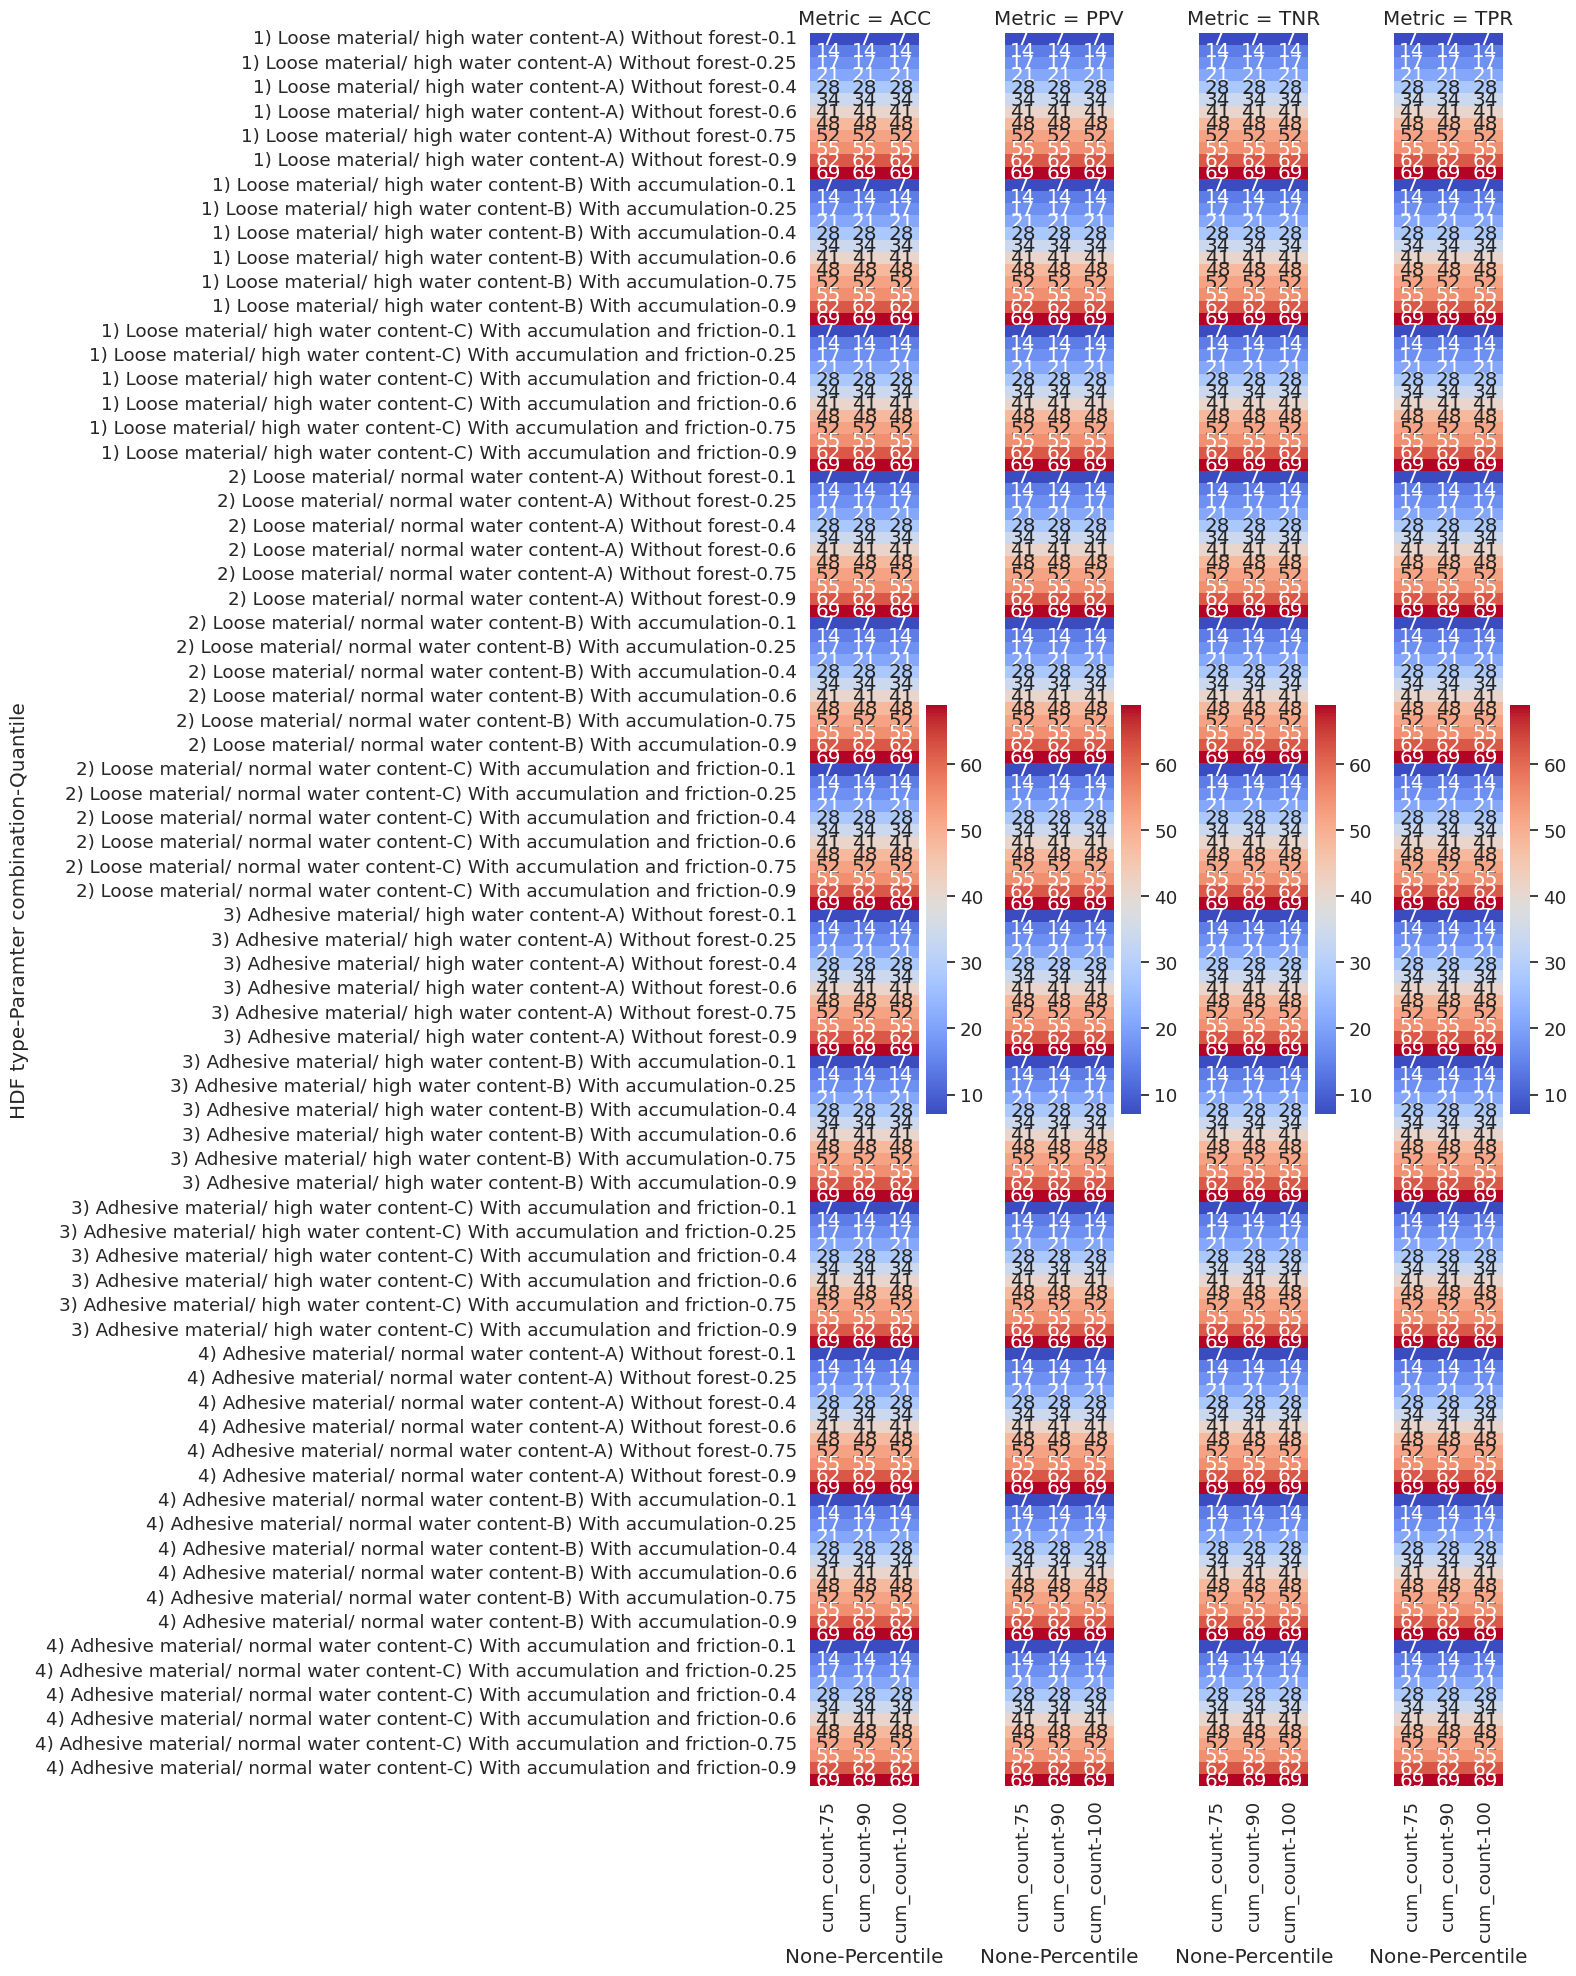

In [29]:
# Output of cumulative counts as heatmaps
df = df_mlt_quant

g = sns.FacetGrid(df, col="Metric", height=20, aspect= 0.2/1)

def draw_heatmap(data, **kwargs):
    pvt = data.pivot_table(index=["HDF type", "Paramter combination","Quantile"], columns=["Percentile"],values=["cum_count"],sort=False)
    sns.heatmap(pvt, annot=True,cmap = "coolwarm")

g.map_dataframe(draw_heatmap)


In [30]:
df = df_sim_combined
df[(df["slide_type"]==0) & (df["forest"]==0) & (df["Percentile"]==100) & (df["in_forest"]>=0)]["in_forest"].unique()

array([1, 0])

### Analysis 100th Percentile


Heatmaps of the accuracy by paramter combination.

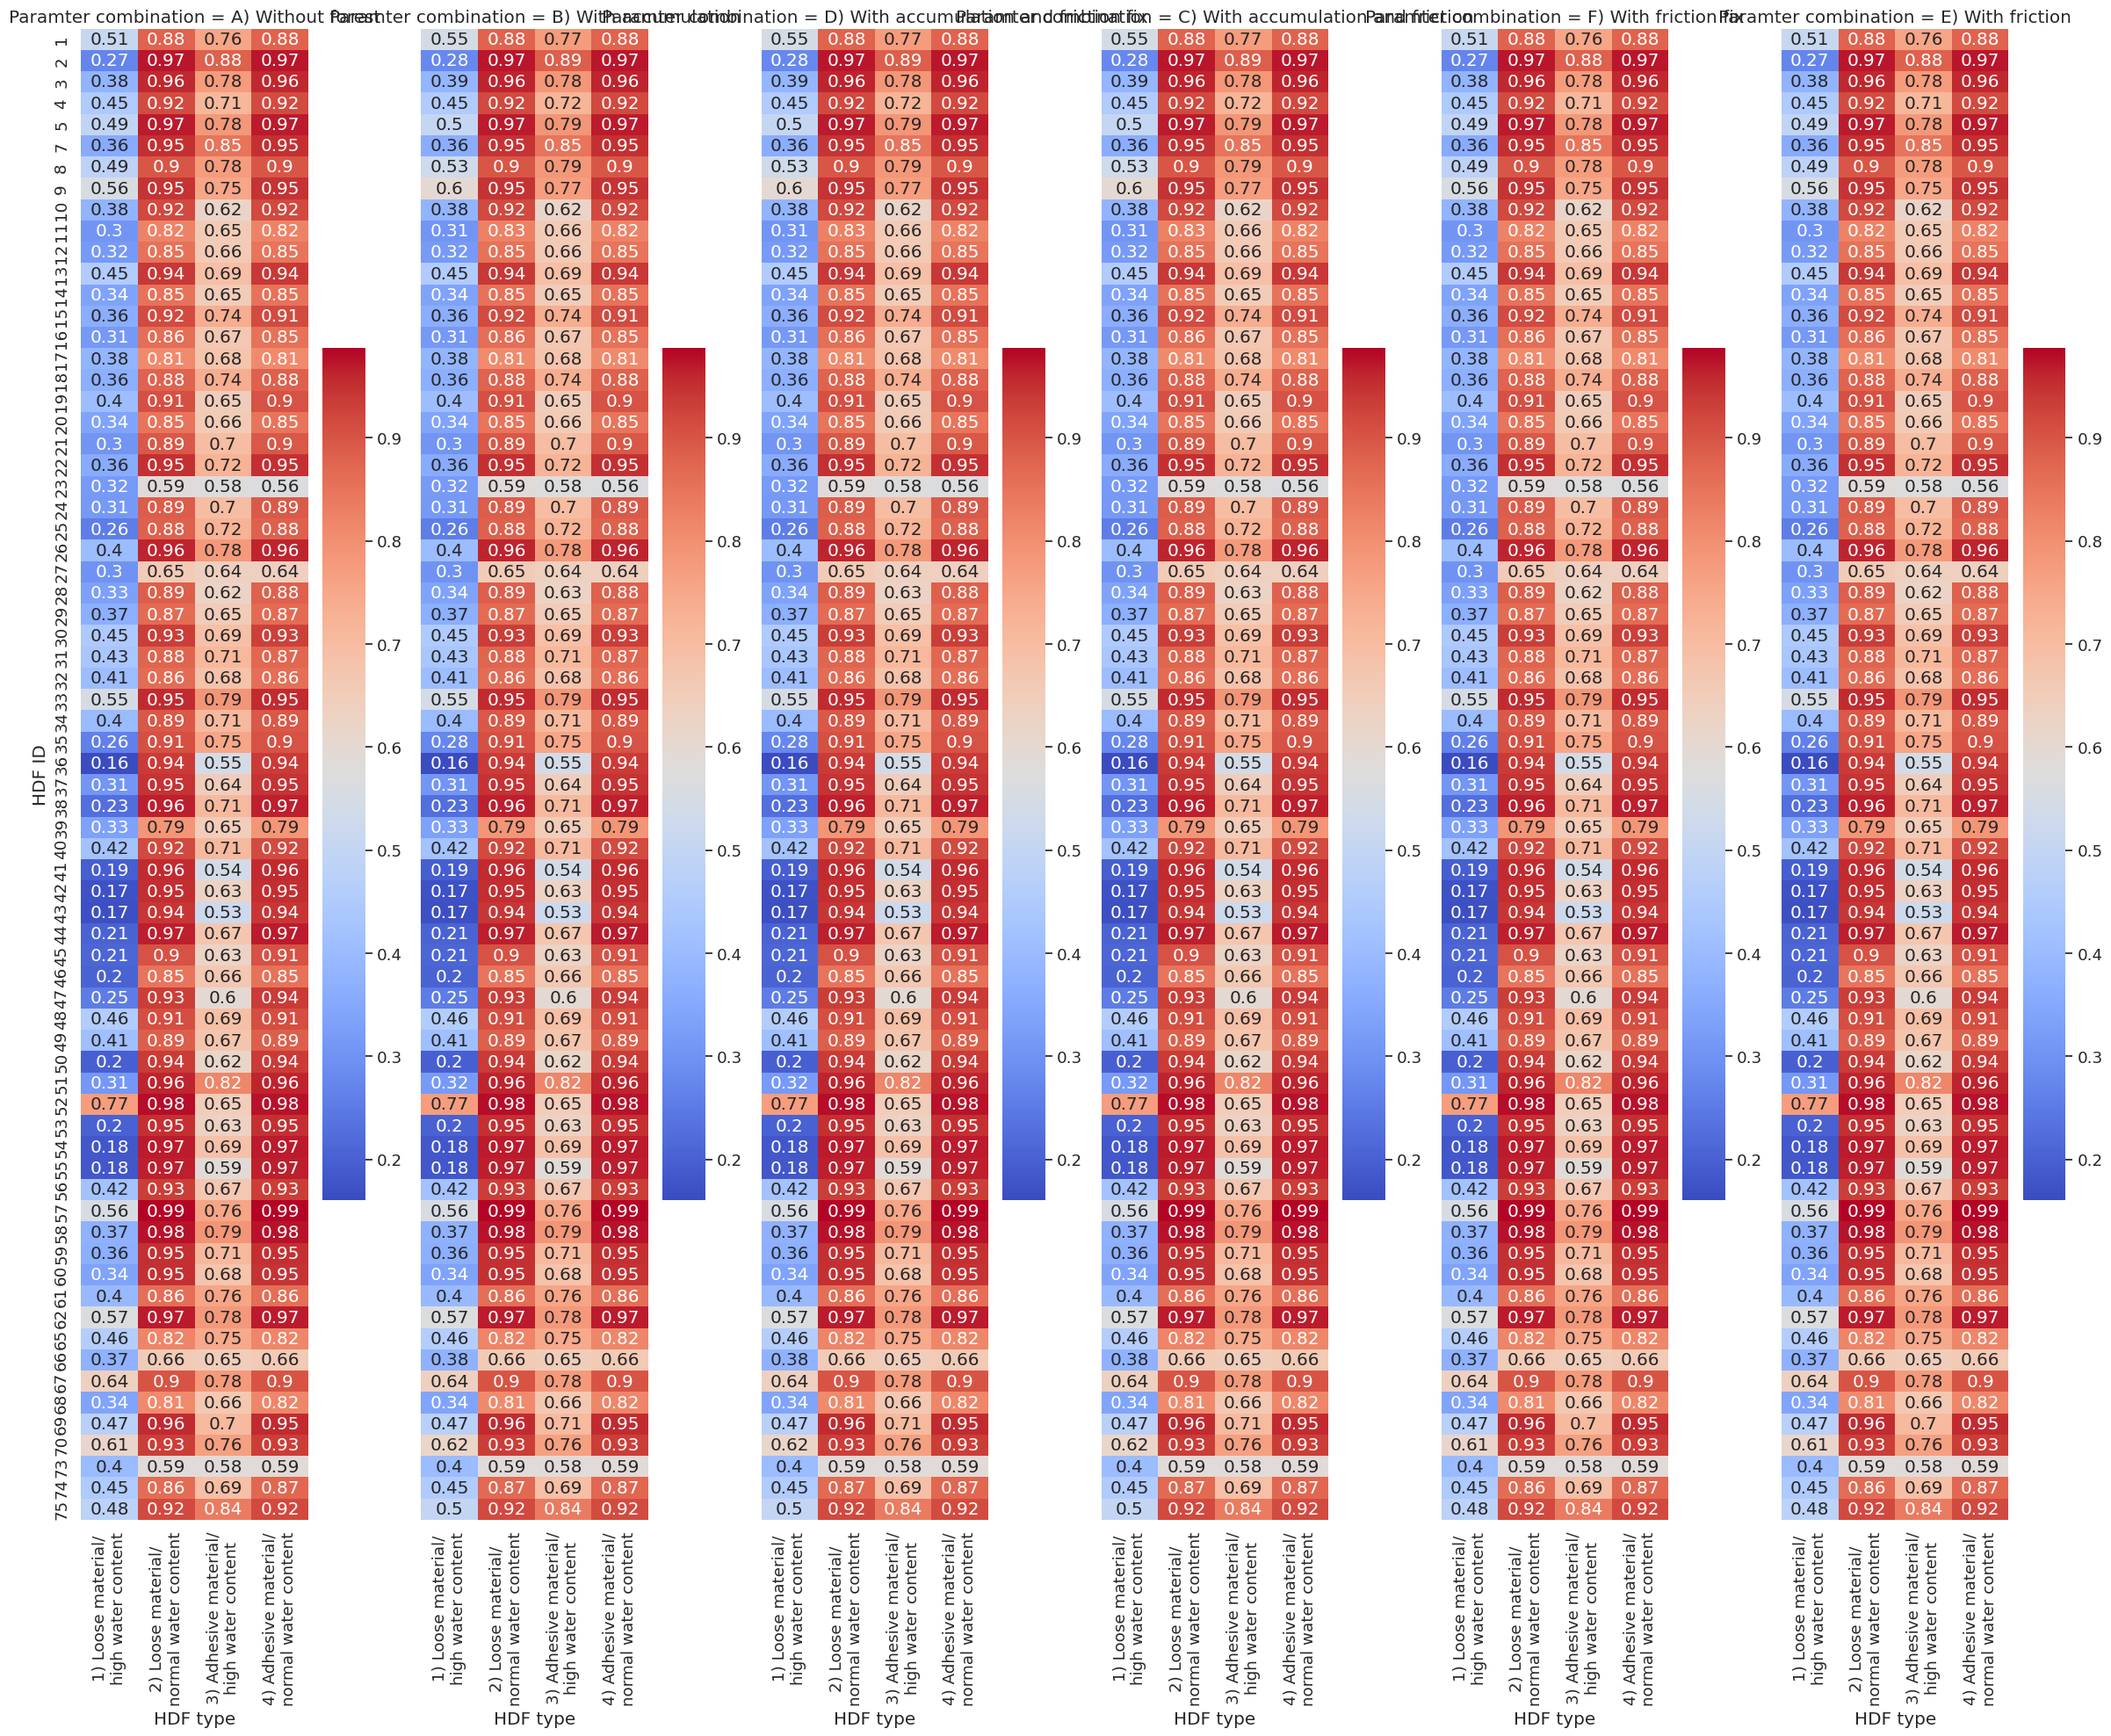

In [31]:
df = df_sim_combined[(df_sim_combined["forest"]>=0) & (df_sim_combined["in_forest"]>=0)]

g = sns.FacetGrid(df, col="Paramter combination", height=20, aspect= 0.2/1)

def draw_heatmap(data, **kwargs):
    pvt = data.pivot(index=["HDF ID"], columns="HDF type",values="ACC")
    sns.heatmap(pvt, annot=True,cmap = "coolwarm")

g.map_dataframe(draw_heatmap)

Heatmaps of all four performance metrics for simulations without forest effect.

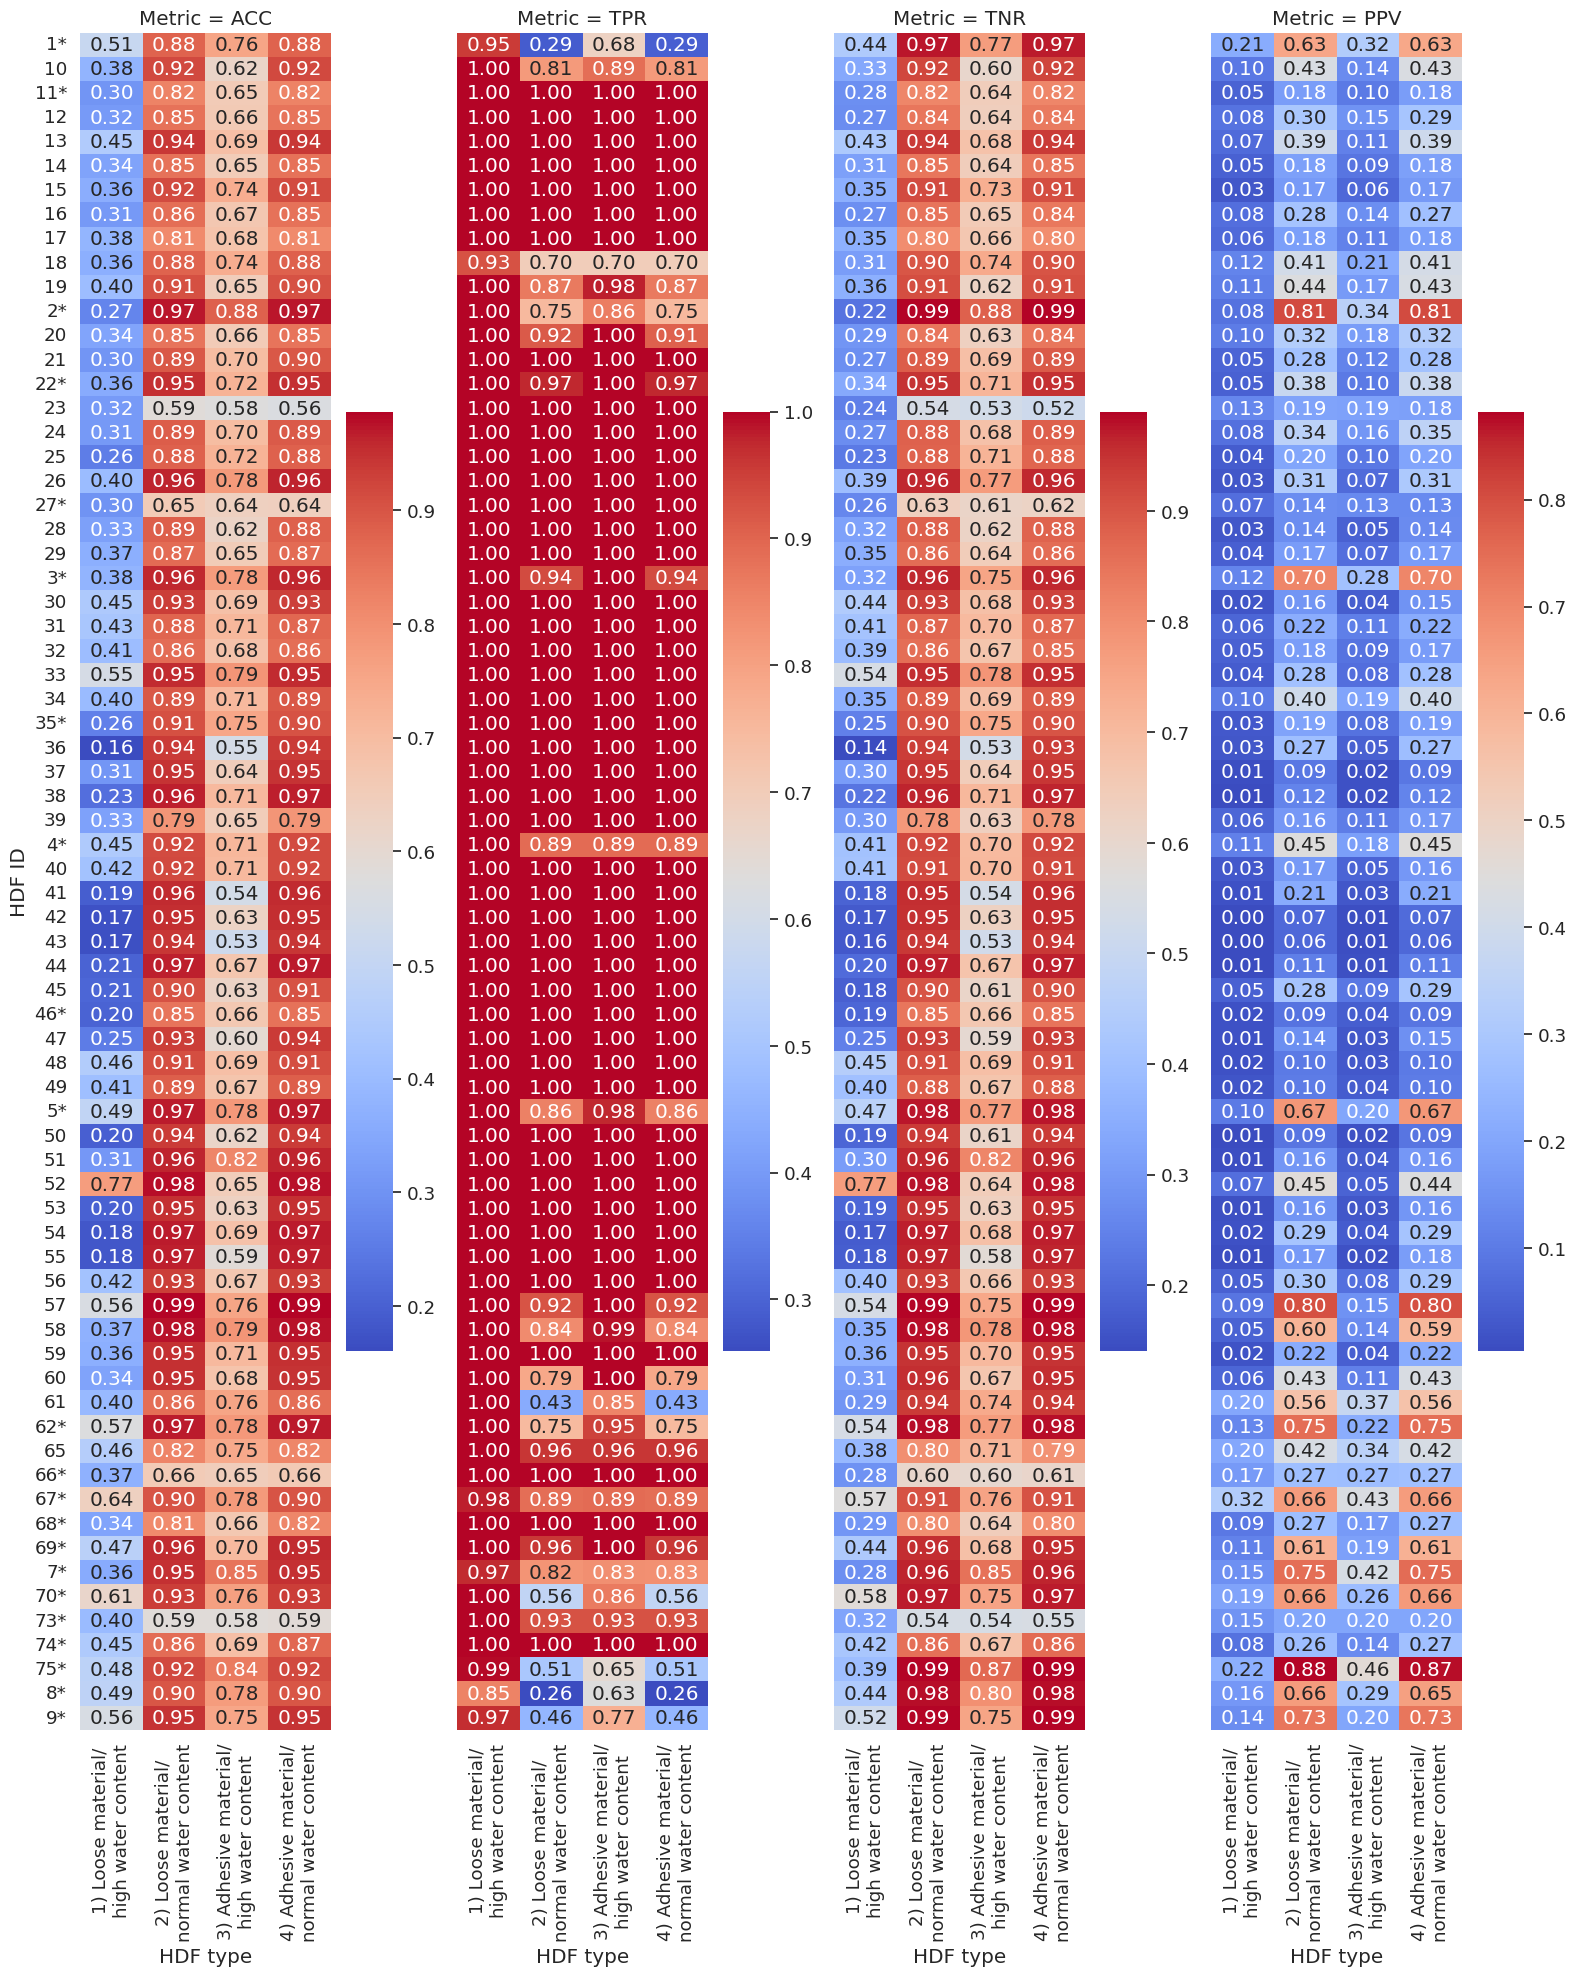

In [32]:
df = df_sim_combined[(df_sim_combined["forest"]==0) & (df_sim_combined["in_forest"]>=0)].reset_index()

forest_slide_id = df[df["in_forest"]>0]["HDF ID"].unique()

metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df_melt = pd.melt(df, id_vars=["HDF type","HDF ID",], value_vars=["ACC","TPR","TNR","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])
df_melt["HDF ID"] = df_melt["HDF ID"].apply(lambda x: "{0}{1}".format(x,"*" if x in forest_slide_id else ""))

df_melt.rename(columns={"value":"Value" }, inplace=True)
df_melt = df_melt.sort_values(by=["HDF ID","metric_order"]).reset_index()

g = sns.FacetGrid(df_melt, col="Metric", height=20, aspect= 0.2/1)
def draw_heatmap(data, **kwargs):
    pvt = data.pivot_table(index=["HDF ID"], columns="HDF type",values="Value",sort=False)

    sns.heatmap(pvt, annot=True,cmap = "coolwarm",fmt=".2f")

g.map_dataframe(draw_heatmap)


Statistics on all four performance metrics.

In [33]:
sim_agg = df_sim_combined[(df_sim_combined["in_forest"]>=0)].groupby(by=["HDF type","Paramter combination"])[["AUC","TPR","TNR","PPV"]].describe()
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(sim_agg)


AUC  \
                                                                                  count   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                      70.0   
                                            B) With accumulation                   70.0   
                                            C) With accumulation and friction      70.0   
                                            D) With accumulation and friction fix  70.0   
                                            E) With friction                       70.0   
                                            F) With friction fix                   70.0   
2) Loose material/\nnormal water content    A) Without forest                      70.0   
                                            B) With accumulation                   70.0   
                                            C) With accumulation and friction      70.0   
                                            D) With accumulation and friction fix  70.0   
                                            E) With friction                       70.0   
                                            F) With friction fix                   70.0   
3) Adhesive material/\nhigh water content   A) Without forest                      70.0   
                                            B) With accumulation                   70.0   
                                            C) With accumulation and friction      70.0   
                                            D) With accumulation and friction fix  70.0   
                                            E) With friction                       70.0   
                                            F) With friction fix                   70.0   
4) Adhesive material/\nnormal water content A) Without forest                      70.0   
                                            B) With accumulation                   70.0   
                                            C) With accumulation and friction      70.0   
                                            D) With accumulation and friction fix  70.0   
                                            E) With friction                       70.0   
                                            F) With friction fix                   70.0   

                                                                                          \
                                                                                    mean   
HDF type                                    Paramter combination                           
1) Loose material/\nhigh water content      A) Without forest                      0.913   
                                            B) With accumulation                   0.913   
                                            C) With accumulation and friction      0.913   
                                            D) With accumulation and friction fix  0.913   
                                            E) With friction                       0.913   
                                            F) With friction fix                   0.913   
2) Loose material/\nnormal water content    A) Without forest                      0.946   
                                            B) With accumulation                   0.945   
                                            C) With accumulation and friction      0.945   
                                            D) With accumulation and friction fix  0.945   
                                            E) With friction                       0.946   
                                            F) With friction fix                   0.946   
3) Adhesive material/\nhigh water content   A) Without forest                      0.941   
                                            B) With accumulation                   0.941   
                                            C) With accumulati

Statistics on all four performance metrics for forest plots only.

In [34]:
sim_agg = df_sim_combined[(df_sim_combined["in_forest"]>0)].groupby(by=["HDF type","Paramter combination"])[["AUC","TPR","TNR","PPV"]].describe()
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(sim_agg)


AUC  \
                                                                                  count   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                      22.0   
                                            B) With accumulation                   22.0   
                                            C) With accumulation and friction      22.0   
                                            D) With accumulation and friction fix  22.0   
                                            E) With friction                       22.0   
                                            F) With friction fix                   22.0   
2) Loose material/\nnormal water content    A) Without forest                      22.0   
                                            B) With accumulation                   22.0   
                                            C) With accumulation and friction      22.0   
                                            D) With accumulation and friction fix  22.0   
                                            E) With friction                       22.0   
                                            F) With friction fix                   22.0   
3) Adhesive material/\nhigh water content   A) Without forest                      22.0   
                                            B) With accumulation                   22.0   
                                            C) With accumulation and friction      22.0   
                                            D) With accumulation and friction fix  22.0   
                                            E) With friction                       22.0   
                                            F) With friction fix                   22.0   
4) Adhesive material/\nnormal water content A) Without forest                      22.0   
                                            B) With accumulation                   22.0   
                                            C) With accumulation and friction      22.0   
                                            D) With accumulation and friction fix  22.0   
                                            E) With friction                       22.0   
                                            F) With friction fix                   22.0   

                                                                                          \
                                                                                    mean   
HDF type                                    Paramter combination                           
1) Loose material/\nhigh water content      A) Without forest                      0.927   
                                            B) With accumulation                   0.927   
                                            C) With accumulation and friction      0.927   
                                            D) With accumulation and friction fix  0.927   
                                            E) With friction                       0.927   
                                            F) With friction fix                   0.927   
2) Loose material/\nnormal water content    A) Without forest                      0.890   
                                            B) With accumulation                   0.889   
                                            C) With accumulation and friction      0.889   
                                            D) With accumulation and friction fix  0.889   
                                            E) With friction                       0.890   
                                            F) With friction fix                   0.890   
3) Adhesive material/\nhigh water content   A) Without forest                      0.923   
                                            B) With accumulation                   0.923   
                                            C) With accumulati

Table with mean values of the performance metrics for all paramter combinations.

In [35]:
sim_agg = df_sim_combined[(df_sim_combined["in_forest"]>=0)].groupby(by=["HDF type","Paramter combination"]).agg(
    {"ACC":["mean"],"TPR":["mean"],"TNR":["mean"],"PPV":["mean"]}
)

with pd.option_context("display.max_rows", 200, "display.max_columns", 25, "display.float_format", "{:.1%}".format):
    display(sim_agg)

# print(sim_agg.to_latex(bold_rows=True,float_format="{:,.1%}".format))


ACC  \
                                                                                   mean   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                     36.7%   
                                            B) With accumulation                  37.1%   
                                            C) With accumulation and friction     37.1%   
                                            D) With accumulation and friction fix 37.1%   
                                            E) With friction                      36.7%   
                                            F) With friction fix                  36.7%   
2) Loose material/\nnormal water content    A) Without forest                     89.7%   
                                            B) With accumulation                  89.7%   
                                            C) With accumulation and friction     89.7%   
                                            D) With accumulation and friction fix 89.7%   
                                            E) With friction                      89.7%   
                                            F) With friction fix                  89.7%   
3) Adhesive material/\nhigh water content   A) Without forest                     69.4%   
                                            B) With accumulation                  69.5%   
                                            C) With accumulation and friction     69.5%   
                                            D) With accumulation and friction fix 69.5%   
                                            E) With friction                      69.4%   
                                            F) With friction fix                  69.4%   
4) Adhesive material/\nnormal water content A) Without forest                     89.6%   
                                            B) With accumulation                  89.6%   
                                            C) With accumulation and friction     89.6%   
                                            D) With accumulation and friction fix 89.6%   
                                            E) With friction                      89.6%   
                                            F) With friction fix                  89.6%   

                                                                                    TPR  \
                                                                                   mean   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                     99.5%   
                                            B) With accumulation                  99.4%   
                                            C) With accumulation and friction     99.4%   
                                            D) With accumulation and friction fix 99.4%   
                                            E) With friction                      99.5%   
                                            F) With friction fix                  99.5%   
2) Loose material/\nnormal water content    A) Without forest                     91.5%   
                                            B) With accumulation                  91.5%   
                                            C) With accumulation and friction     91.5%   
                                            D) With accumulation and friction fix 91.5%   
                                            E) With friction                      91.5%   
                                            F) With friction fix                  91.5%   
3) Adhesive material/\nhigh water content   A) Without forest                     96.1%   
                                            B) With accumulation                  96.1%   
                                            C) With accumulation and friction  

Table with mean values of the performance metrics for selected paramter combinations (main results).

In [36]:
sim_agg = df_sim_combined[(df_sim_combined["in_forest"]>=0) & df_sim_combined["forest"].isin([0,1,3])].groupby(by=["HDF type","Paramter combination"]).agg(
    {"ACC":["count","mean"],"TPR":["mean"],"TNR":["mean"],"PPV":["mean"]}
)

with pd.option_context("display.max_rows", 200, "display.max_columns", 25, "display.float_format", "{:.1%}".format):
    display(sim_agg)

print(sim_agg.to_latex(bold_rows=True,float_format="{:,.1%}".format))


ACC  \
                                                                              count   
HDF type                                    Paramter combination                      
1) Loose material/\nhigh water content      A) Without forest                    70   
                                            B) With accumulation                 70   
                                            C) With accumulation and friction    70   
2) Loose material/\nnormal water content    A) Without forest                    70   
                                            B) With accumulation                 70   
                                            C) With accumulation and friction    70   
3) Adhesive material/\nhigh water content   A) Without forest                    70   
                                            B) With accumulation                 70   
                                            C) With accumulation and friction    70   
4) Adhesive material/\nnormal water content A) Without forest                    70   
                                            B) With accumulation                 70   
                                            C) With accumulation and friction    70   

                                                                                     \
                                                                               mean   
HDF type                                    Paramter combination                      
1) Loose material/\nhigh water content      A) Without forest                 36.7%   
                                            B) With accumulation              37.1%   
                                            C) With accumulation and friction 37.1%   
2) Loose material/\nnormal water content    A) Without forest                 89.7%   
                                            B) With accumulation              89.7%   
                                            C) With accumulation and friction 89.7%   
3) Adhesive material/\nhigh water content   A) Without forest                 69.4%   
                                            B) With accumulation              69.5%   
                                            C) With accumulation and friction 69.5%   
4) Adhesive material/\nnormal water content A) Without forest                 89.6%   
                                            B) With accumulation              89.6%   
                                            C) With accumulation and friction 89.6%   

                                                                                TPR  \
                                                                               mean   
HDF type                                    Paramter combination                      
1) Loose material/\nhigh water content      A) Without forest                 99.5%   
                                            B) With accumulation              99.4%   
                                            C) With accumulation and friction 99.4%   
2) Loose material/\nnormal water content    A) Without forest                 91.5%   
                                            B) With accumulation              91.5%   
                                            C) With accumulation and friction 91.5%   
3) Adhesive material/\nhigh water content   A) Without forest                 96.1%   
                                            B) With accumulation              96.1%   
                                            C) With accumulation and friction 96.1%   
4) Adhesive material/\nnormal water content A) Without forest                 91.5%   
                                            B) With accumulation              91.4%   
                                            C) With accumulation and friction 91.4%   

                                                                                TNR  \
                                                                           

\begin{tabular}{llrrrrr}
\toprule
 &  & \multicolumn{2}{r}{ACC} & TPR & TNR & PPV \\
 &  & count & mean & mean & mean & mean \\
HDF type & Paramter combination &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{1) Loose material/
high water content}} & \textbf{A) Without forest} & 70 & 36.7% & 99.5% & 33.6% & 7.5% \\
\textbf{} & \textbf{B) With accumulation} & 70 & 37.1% & 99.4% & 34.0% & 7.6% \\
\textbf{} & \textbf{C) With accumulation and friction} & 70 & 37.1% & 99.4% & 34.0% & 7.6% \\
\cline{1-7}
\multirow[t]{3}{*}{\textbf{2) Loose material/
normal water content}} & \textbf{A) Without forest} & 70 & 89.7% & 91.5% & 89.9% & 33.4% \\
\textbf{} & \textbf{B) With accumulation} & 70 & 89.7% & 91.5% & 90.0% & 33.5% \\
\textbf{} & \textbf{C) With accumulation and friction} & 70 & 89.7% & 91.5% & 90.0% & 33.5% \\
\cline{1-7}
\multirow[t]{3}{*}{\textbf{3) Adhesive material/
high water content}} & \textbf{A) Without forest} & 70 & 69.4% & 96.1% & 68.3% & 13.6% \\
\textbf{} & \textbf{B) Wi

Table with mean values of the performance metrics for selected paramter combinations for forest plots only.

In [37]:
sim_agg = df_sim_combined[(df_sim_combined["in_forest"]>0)].groupby(by=["HDF type","Paramter combination"]).agg(
    {"ACC":["count","mean"],"TPR":["mean"],"TNR":["mean"],"PPV":["mean"]}
)

with pd.option_context("display.max_rows", 200, "display.max_columns", 25, "display.float_format", "{:.1%}".format):
    display(sim_agg)

# print(sim_agg.to_latex(bold_rows=True,float_format="{:,.1%}".format))


ACC  \
                                                                                  count   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                        22   
                                            B) With accumulation                     22   
                                            C) With accumulation and friction        22   
                                            D) With accumulation and friction fix    22   
                                            E) With friction                         22   
                                            F) With friction fix                     22   
2) Loose material/\nnormal water content    A) Without forest                        22   
                                            B) With accumulation                     22   
                                            C) With accumulation and friction        22   
                                            D) With accumulation and friction fix    22   
                                            E) With friction                         22   
                                            F) With friction fix                     22   
3) Adhesive material/\nhigh water content   A) Without forest                        22   
                                            B) With accumulation                     22   
                                            C) With accumulation and friction        22   
                                            D) With accumulation and friction fix    22   
                                            E) With friction                         22   
                                            F) With friction fix                     22   
4) Adhesive material/\nnormal water content A) Without forest                        22   
                                            B) With accumulation                     22   
                                            C) With accumulation and friction        22   
                                            D) With accumulation and friction fix    22   
                                            E) With friction                         22   
                                            F) With friction fix                     22   

                                                                                         \
                                                                                   mean   
HDF type                                    Paramter combination                          
1) Loose material/\nhigh water content      A) Without forest                     42.1%   
                                            B) With accumulation                  43.1%   
                                            C) With accumulation and friction     43.1%   
                                            D) With accumulation and friction fix 43.1%   
                                            E) With friction                      42.1%   
                                            F) With friction fix                  42.1%   
2) Loose material/\nnormal water content    A) Without forest                     87.6%   
                                            B) With accumulation                  87.6%   
                                            C) With accumulation and friction     87.6%   
                                            D) With accumulation and friction fix 87.6%   
                                            E) With friction                      87.6%   
                                            F) With friction fix                  87.6%   
3) Adhesive material/\nhigh water content   A) Without forest                     73.5%   
                                            B) With accumulation                  73.9%   
                                            C) With accumulation and friction  

Box plots of all performance metrics for all plots

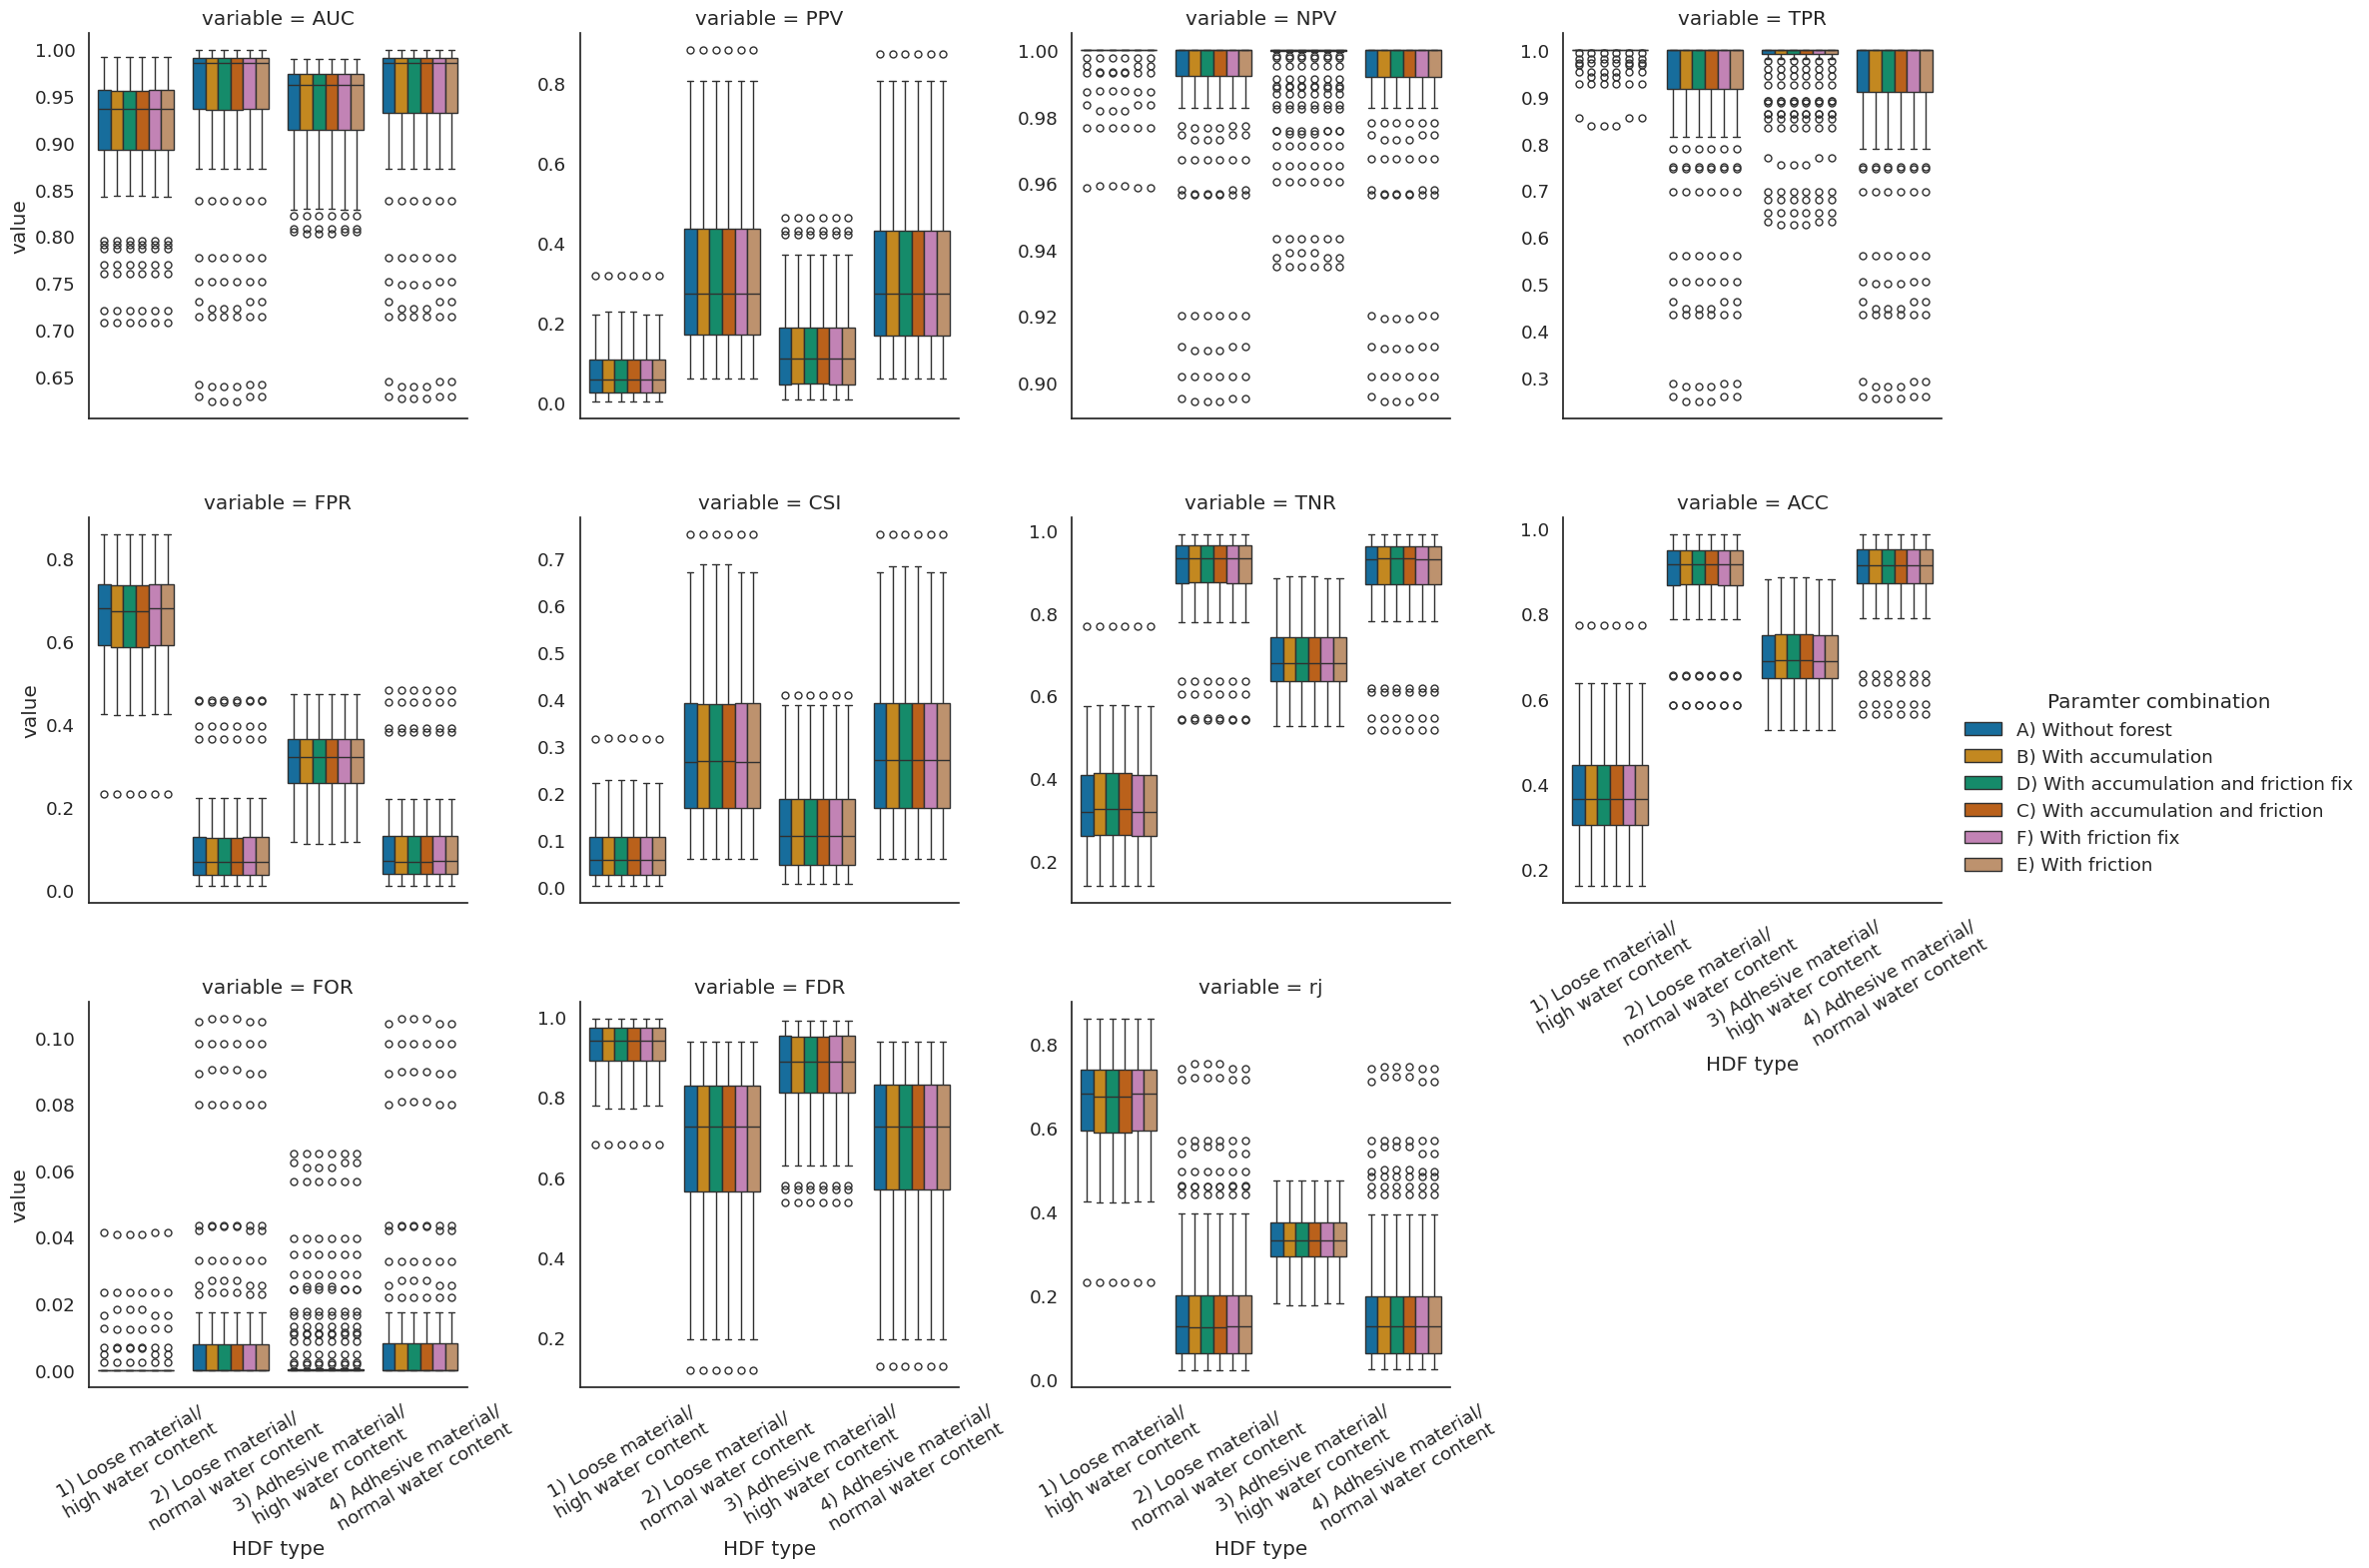

In [38]:
df_melt = pd.melt(df_sim_combined[((df_sim_combined["forest"]>=0)&(df_sim_combined["in_forest"]>=0)) | ((df_sim_combined["forest"]==0)&(df_sim_combined["in_forest"]>=0))], id_vars=["HDF type","slide_type","HDF ID","Paramter combination","in_forest"], value_vars=["AUC", "PPV", "NPV", "TPR", "FPR", "CSI", "TNR", "ACC", "FOR", "FDR","rj"])
g = sns.catplot(data=df_melt, x="HDF type", y="value",hue="Paramter combination",  kind="box", col="variable", col_wrap=4, sharex=True,sharey=False, showfliers = True,palette=sns.color_palette("colorblind",6), margin_titles=True, legend=True )

g.tick_params(axis='x', which='both', rotation=30)
    

Box plots of the four main performance metrics for all paramter combinations.

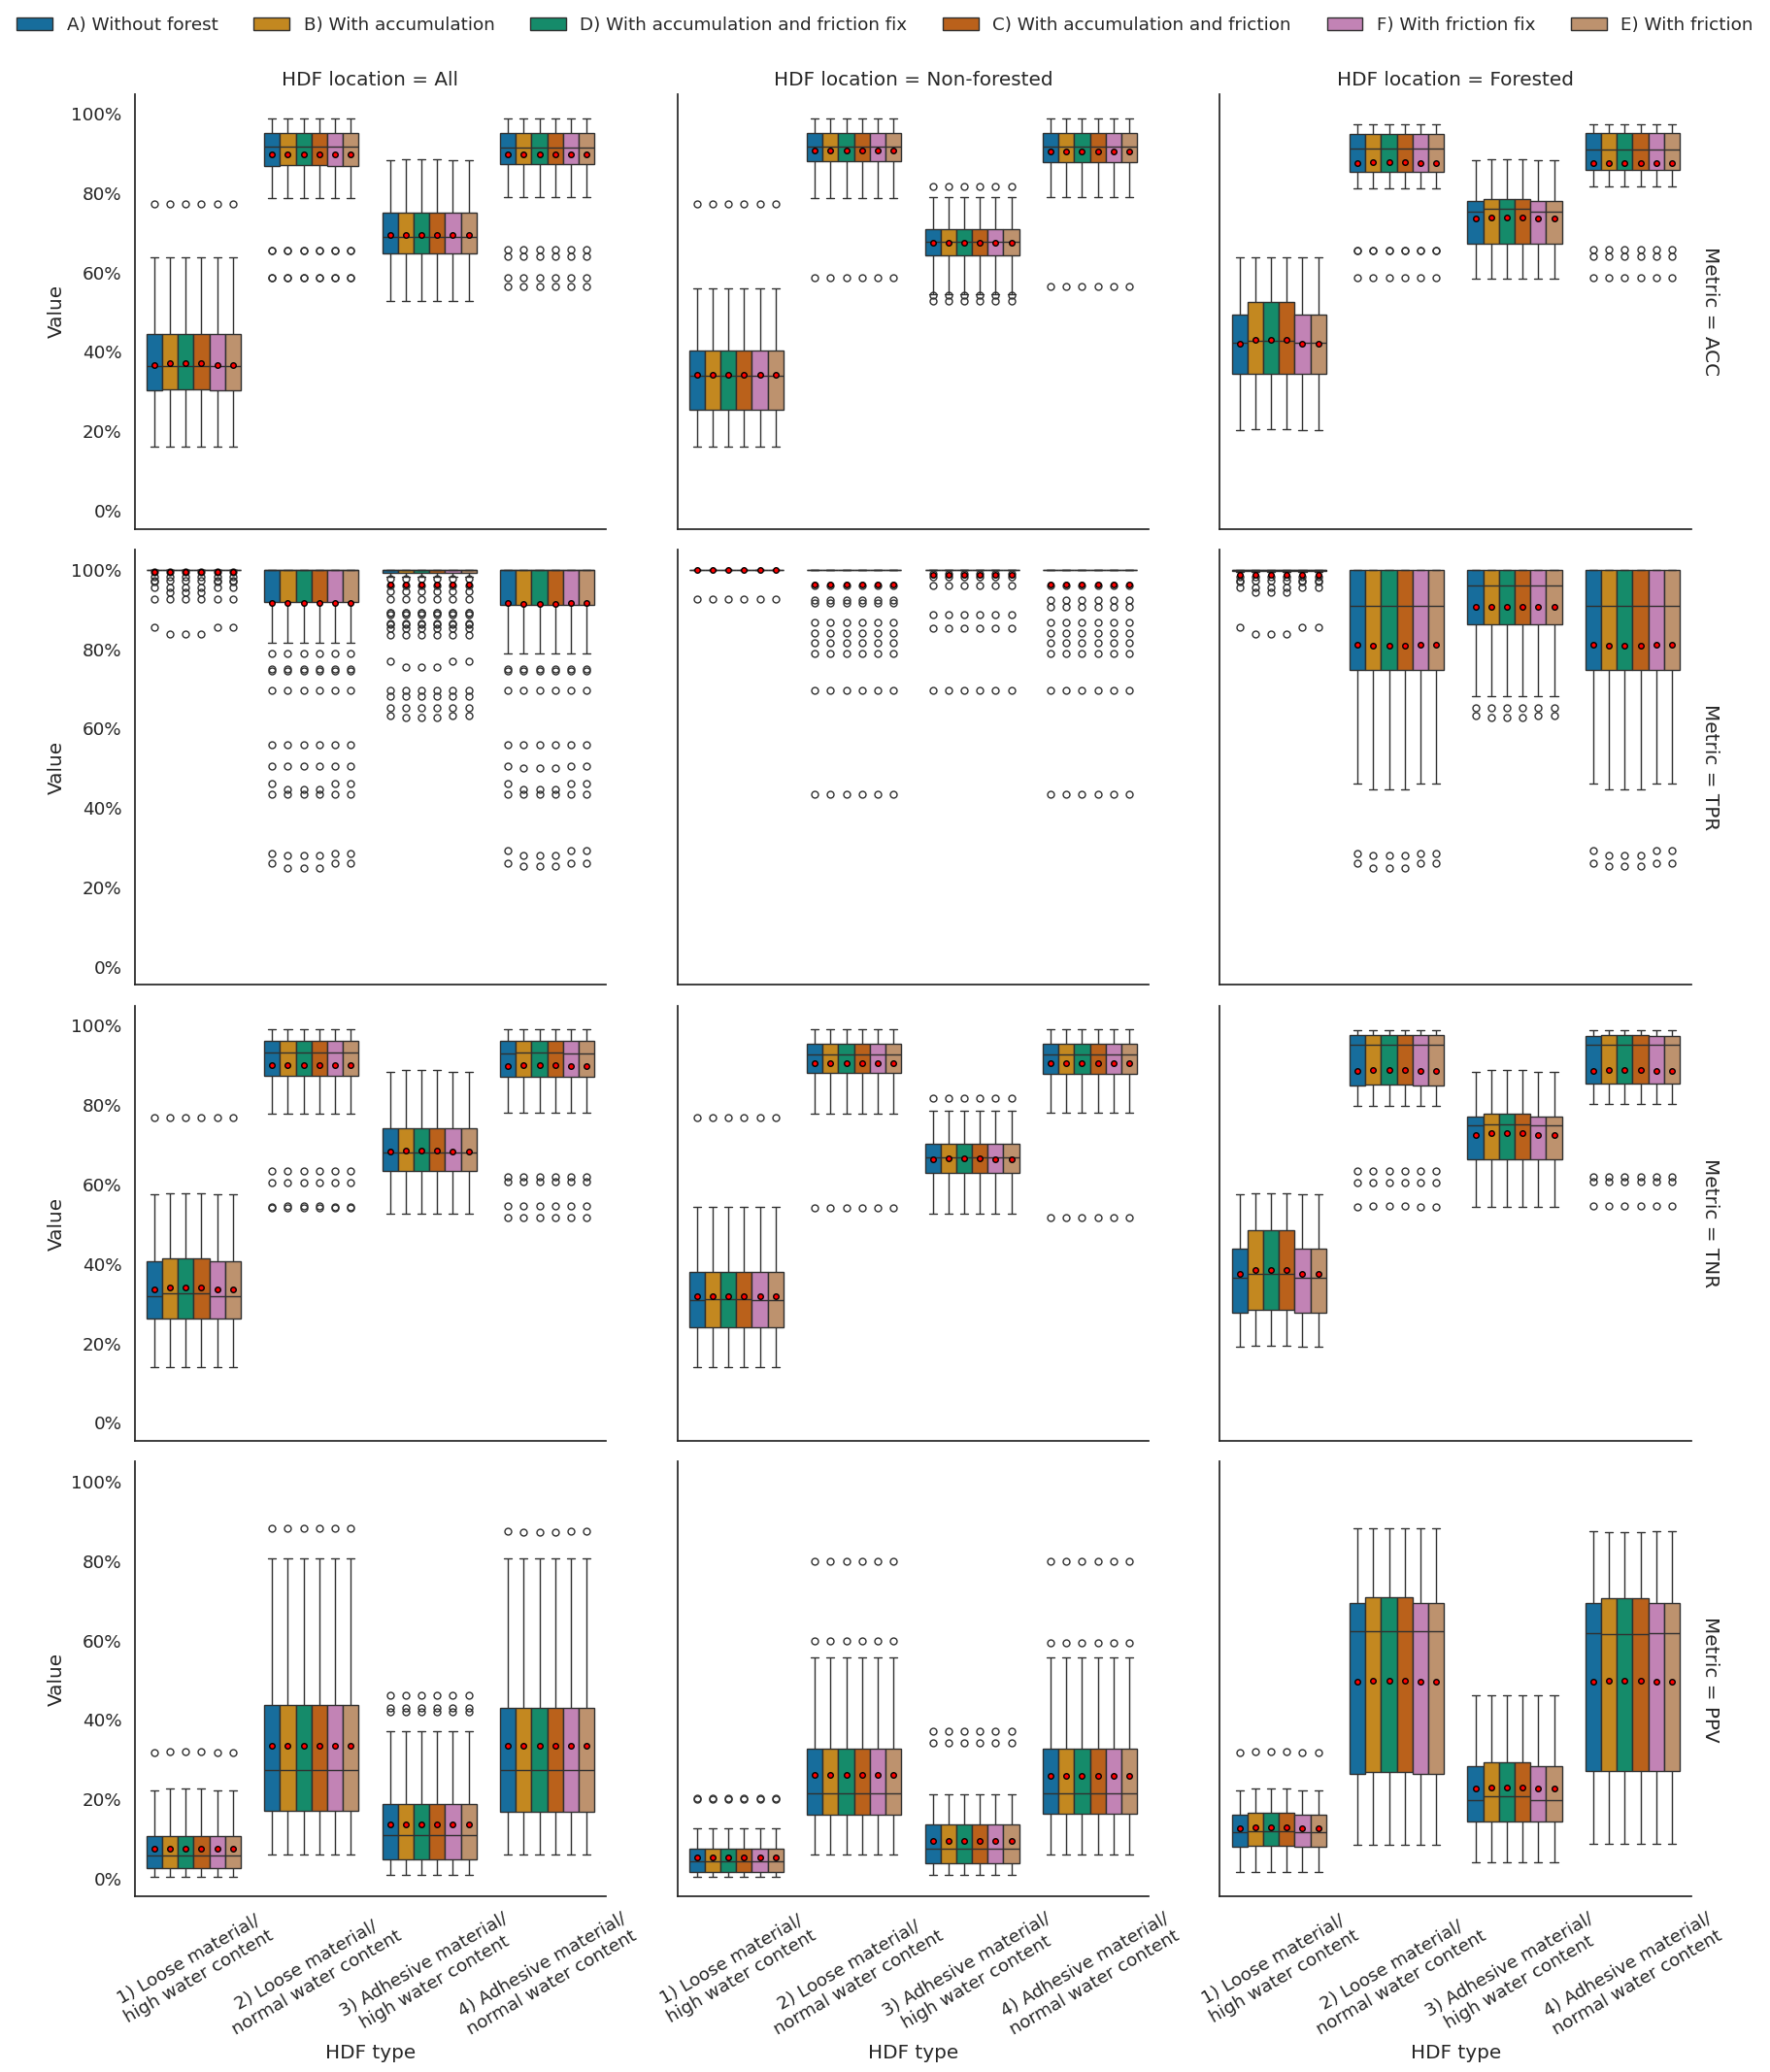

In [39]:
metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df_melt = pd.melt(df_sim_combined, id_vars=["HDF type","slide_type","HDF ID","Paramter combination","in_forest","HDF location"], value_vars=["TPR","TNR","ACC","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])

df_melt.rename(columns={"value":"Value"}, inplace=True)

sns.set(font_scale=1.2)
sns.set_style("white")

df_melt = df_melt.sort_values(by=["in_forest","metric_order"])
fig = sns.catplot(data=df_melt, x="HDF type", y="Value",hue="Paramter combination",   row="Metric", col="HDF location", 
                  kind="box", sharex=True,sharey=True, showfliers = True,palette=sns.color_palette("colorblind",6), 
                  margin_titles=True, legend=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'},
                  height = 5, aspect = 1.2
                 )

fig.tick_params(axis='x', which='both', rotation=30)

for ax in fig.axes.flatten():
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.4, 1), 
    ncol=6, title=None, frameon=False,
)

Box plots of the four main performance metrics for selected paramter combinations (main results).

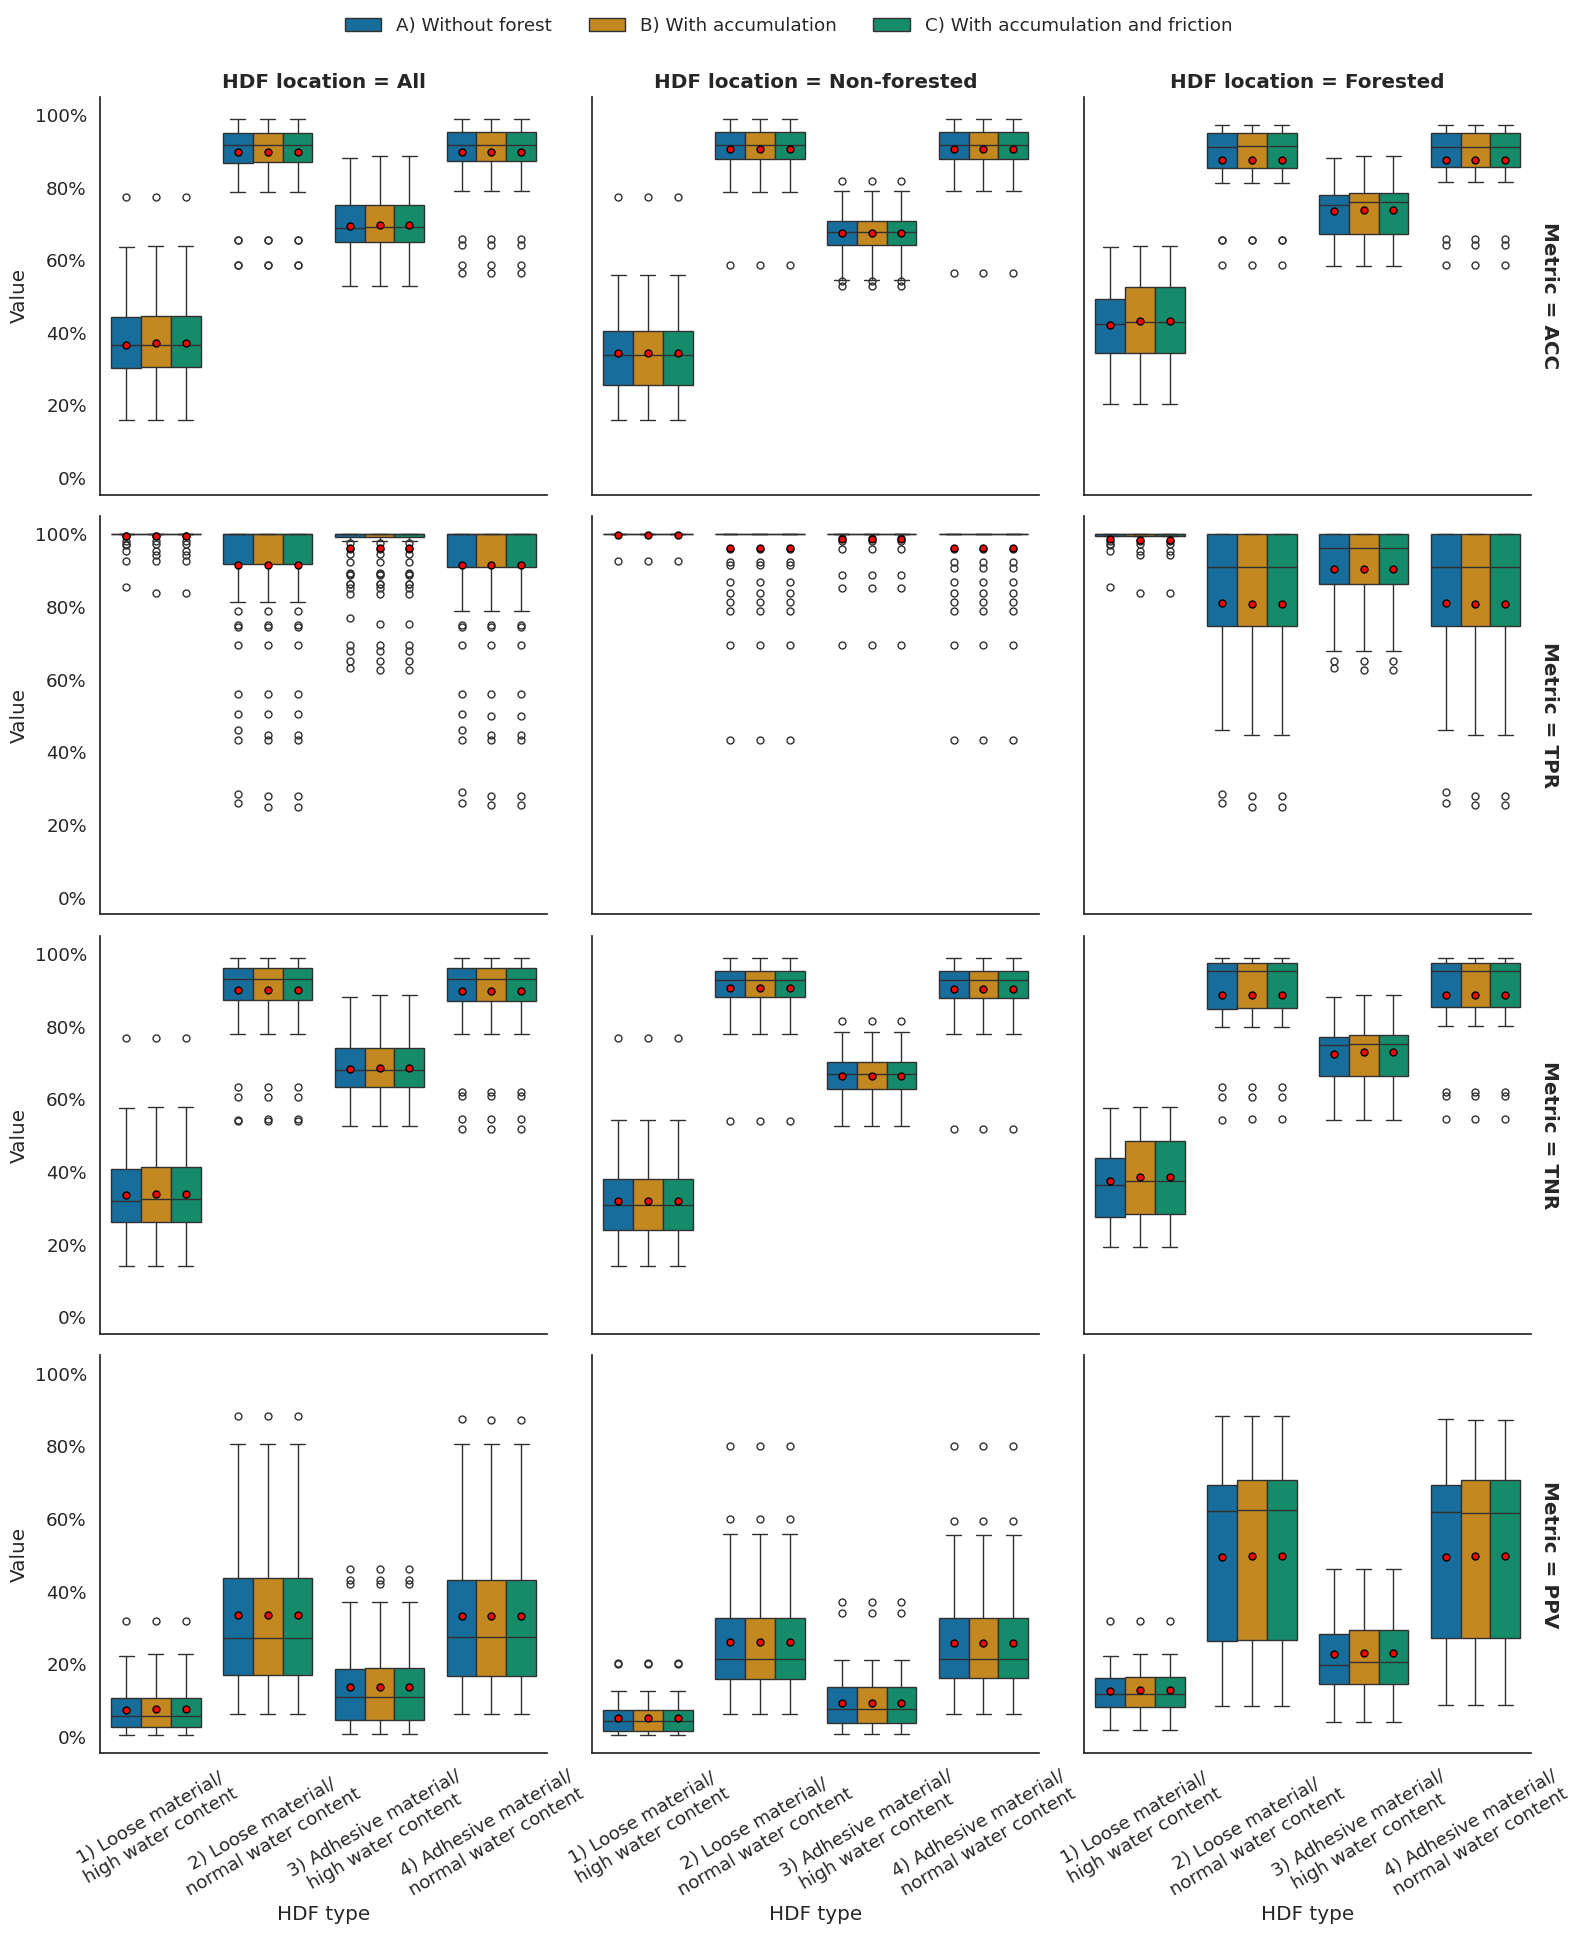

In [40]:
# Reshaping the data
metric_order = {"TPR":1,"TNR":2,"ACC":0,"PPV":3}
df_melt = pd.melt(df_sim_combined, id_vars=["HDF type","slide_type","HDF ID","Paramter combination","forest","in_forest","HDF location"], value_vars=["TPR","TNR","ACC","PPV"])
df_melt["Metric"] = df_melt["variable"].apply(lambda x: x.upper())
df_melt["metric_order"] = df_melt["variable"].apply(lambda x: metric_order[x])
df_melt.rename(columns={"value":"Value"}, inplace=True)

# Selecting only the three main paramter combinations
df_melt = df_melt[df_melt["forest"].isin([0,1,3])]

sns.set(font_scale=1.2)
sns.set_style("white")

# get the desired order in the figure
df_melt = df_melt.sort_values(by=["in_forest","metric_order"])
fig = sns.catplot(data=df_melt, x="HDF type", y="Value",hue="Paramter combination",   row="Metric", col="HDF location", 
                  kind="box", sharex=True,sharey=True, showfliers = True,palette=sns.color_palette("colorblind",3), 
                  margin_titles=True, legend=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'5'},
                  height = 4.5, aspect = 1.2
                 )

plt.subplots_adjust(wspace=0.1)

# Motify axes
fig.tick_params(axis='x', which='both', rotation=30)
for ax in fig.axes.flatten():
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Set column and row titles for grid
fig.set_titles(template = "", col_template = "HDF location = {col_name}", row_template = "Metric = {row_name}",weight='bold')

# Move legend
sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.4, 1), 
    ncol=6, frameon=False,
    title=""
)

# Save figure
fig.savefig("fig06.png", dpi=600) 
fig.savefig("fig06.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
fig.savefig("fig06.eps", dpi=600)

<a id="SensitivityAnalysis"></a>
## Sensitivity Analysis

### Sensitivity Analysis Constant Gradient Slope with variable Friction

Reading input data for simulation on constant gradient slope with variable friction.

In [41]:
sobol_parameters_path = os.path.join(input_base_path,"sensitivity_constant_slope","sensitivity_param_values_constant_slope.txt")

combination_path = os.path.join(input_base_path,"sensitivity_constant_slope","sim_stats_merged.csv")

In [42]:
df_params = pd.read_csv(sobol_parameters_path,sep=" ",names= ["thickness", "density", "height", "type", "mu", "accumulation"
             ,"size","slope","dbh","stemdensity"])
df_params.head()

thickness      density    height  type   mu  accumulation  size      slope  \
0   1.302808  1568.802995  1.488292   1.0  1.0           1.0   1.0  25.224371   
1   1.988092  1568.802995  1.488292   1.0  1.0           1.0   1.0  25.224371   
2   1.302808  1084.946937  1.488292   1.0  1.0           1.0   1.0  25.224371   
3   1.302808  1568.802995  1.189098   1.0  1.0           1.0   1.0  25.224371   
4   1.302808  1568.802995  1.488292   2.0  1.0           1.0   1.0  25.224371   

         dbh  stemdensity  
0  44.408335   227.933128  
1  44.408335   227.933128  
2  44.408335   227.933128  
3  44.408335   227.933128  
4  44.408335   227.933128

In [43]:
df_combination = pd.read_csv(combination_path,sep=",")

print(len(df_combination))

22528


In [44]:
num_sim = len(df_params)
num_sim

22528

In [45]:
df_combination["step"] = df_combination["step"].astype("int32")
df_combination = df_combination.sort_values(["step"])
df_combination.reset_index(inplace=True)
df_combination.head()


index  step  thickness  density    height  type  friction  deposit  size  \
0      0     0   1.302808     1569  1.488292     1       1.0        1     1   
1      1     1   1.988092     1569  1.488292     1       1.0        1     1   
2      2     2   1.302808     1085  1.488292     1       1.0        1     1   
3      3     3   1.302808     1569  1.189098     1       1.0        1     1   
4      4     4   1.302808     1569  1.488292     2       1.0        1     1   

       slope  ...    w  h  max_spread  n_runout     v_max    v_mean  \
0  25.224371  ...   21  6           6       131  7.774000  6.366535   
1  25.224371  ...   26  8           8       202  8.053102  6.572548   
2  25.224371  ...   21  6           6       131  7.774000  6.366535   
3  25.224371  ...   21  6           6       131  7.774000  6.366535   
4  25.224371  ...  290  8           8      1400  8.442391  5.044210   

       p_max     p_mean    fh_max   fh_mean  
0  47.642414  34.092630  0.350906  0.069339  
1  50.943577  36.485700  0.497681  0.083475  
2  32.945835  23.575846  0.350906  0.069339  
3  47.642414  34.092630  0.350906  0.069339  
4  56.529522  20.612991  1.164638  0.459691  

[5 rows x 26 columns]

In [46]:
df_combination.describe()

index          step     thickness       density        height  \
count  22528.000000  22528.000000  22528.000000  22528.000000  22528.000000   
mean   11263.500000  11263.500000      1.100000   1499.992188      1.250000   
std     6503.417768   6503.417768      0.519627    288.685479      0.433022   
min        0.000000      0.000000      0.200328   1000.000000      0.500046   
25%     5631.750000   5631.750000      0.649935   1249.750000      0.875110   
50%    11263.500000  11263.500000      1.100077   1500.000000      1.250095   
75%    16895.250000  16895.250000      1.548987   1749.250000      1.624888   
max    22527.000000  22527.000000      1.998415   2000.000000      1.999710   

               type      friction       deposit          size         slope  \
count  22528.000000  22528.000000  22528.000000  22528.000000  22528.000000   
mean       1.500488      0.500000      0.500000      1.499512     35.000000   
std        0.957618      0.500011      0.500011      0.956598     14.434077   
min        0.000000      0.000000      0.000000      0.000000     10.014755   
25%        1.000000      0.000000      0.000000      1.000000     22.507970   
50%        1.500000      0.500000      0.500000      1.500000     34.987264   
75%        2.000000      1.000000      1.000000      2.000000     47.487304   
max        3.000000      1.000000      1.000000      3.000000     59.996002   

       ...             w             h    max_spread      n_runout  \
count  ...  22528.000000  22528.000000  22528.000000  22528.000000   
mean   ...    134.987660      8.744895      8.738503   1179.462580   
std    ...    128.030737      4.643785      4.634521   1574.937633   
min    ...      4.000000      2.000000      2.000000      5.000000   
25%    ...     18.000000      6.000000      6.000000    110.000000   
50%    ...     46.000000      8.000000      8.000000    407.000000   
75%    ...    290.000000     10.000000     10.000000   1741.000000   
max    ...    295.000000     34.000000     34.000000   9103.000000   

              v_max        v_mean         p_max        p_mean        fh_max  \
count  22528.000000  22528.000000  22528.000000  22528.000000  22528.000000   
mean       9.925537      7.593538     91.138600     58.048471      0.413682   
std        4.760133      4.012435     58.694197     44.920749      0.263489   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.336590      4.985514     38.756790     19.523632      0.229882   
50%       12.036819      8.309936    100.495008     52.786819      0.378466   
75%       13.987665     10.782869    137.704320     89.549334      0.565564   
max       13.999836     13.661482    198.640030    182.397320      1.790779   

            fh_mean  
count  22528.000000  
mean       0.134044  
std        0.109288  
min        0.000000  
25%        0.059183  
50%        0.090933  
75%        0.222831  
max        0.584671  

[8 rows x 26 columns]

Problem definition.

In [47]:
problem = {
    "num_vars": 10,
    "names": ["thickness", "density", "height", "type", "mu", "accumulation"
             ,"size","slope","dbh","stemdensity"],
    "bounds": [[0.2, 2], # slide thickness
               [1000, 2000], # moving mass density
               [0.5, 2], #maximum flow height
               [0,3], # hdf type
               [0,1], # forest friction
               [0,1], # forest debris accumulation
               [0,3], # start size class
               [10,60], # slope gradient 
               [20,50], # DBH
               [200,600] # stem density per ha
               ]
}

# Read parameter values from simulation input
param_values = np.loadtxt(sobol_parameters_path) 



Function for perfomrming the Sobol analysis with respect to a specific target variable.

In [48]:
def analyze_sensitivity(df, param_vals, problem_dict, x_col, y_col):
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    
    print(np.shape(param_vals))
    print(np.shape(x))
    print(np.shape(y))
    
    sp = ProblemSpec(problem_dict)
    sp.set_samples(param_vals)

    sp.set_results(y)
    sp.analyze_sobol(print_to_console=False,seed=10000)

    sp_dfs = sp.to_df()
    result_S1_df = sp_dfs[1].reset_index()
    result_S1_df["S1"] = result_S1_df.apply(lambda row: 0 if (row["S1"]<0) and (abs(row["S1"])-row["S1_conf"]<0) else row["S1"],axis=1)
    
    result_ST_df = sp_dfs[0].reset_index()
    result_ST_df["ST"] = result_ST_df.apply(lambda row: 0 if (row["ST"]<0) and (abs(row["ST"])-row["ST_conf"]<0) else row["ST"],axis=1)
    
    result_S2_df = sp_dfs[2].reset_index()
    result_S2_df["S2"] = result_S2_df.apply(lambda row: 0 if (row["S2"]<0) and (abs(row["S2"])-row["S2_conf"]<0) else row["S2"],axis=1)
    
    result_S1_df["ST"] = result_ST_df["ST"]
    result_S1_df["ST_conf"] = result_ST_df["ST_conf"]

    fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[1, 0.8], figsize=[12,8])
    # fig.suptitle("Sensitivity Analysis")
    
    plt.subplots_adjust(wspace=0.3)
    
    font_size_default = plt.rcParams.get("font.size")
    font_size = 12
    plt.rcParams.update({"font.size": font_size})
    
    cmap = "coolwarm"
    
    result_S1_df = result_S1_df.sort_values(by="S1",ascending=False)
    
    mlt = pd.melt(result_S1_df, id_vars=["index"], value_vars=["S1","ST"])
    pvt = mlt.pivot(index="index", columns="variable",values="value")
    pvt = pvt.sort_values(by=["S1"],ascending=False)
    
    g1 = sns.heatmap(pvt, annot=True, cbar=True, ax=ax1, cmap = cmap)
    g1.set_ylabel("Parameter",fontsize=font_size+2)
    g1.set_xlabel("",fontsize=font_size)
    ax1.set_title("a)", fontfamily='sans-serif', loc='left', fontsize='medium')
    ax1.tick_params(labelsize=font_size)
    
    mlt = pd.melt(result_S2_df, id_vars=["index"], value_vars=["S2"])
    pvt2 = mlt.pivot(index="variable", columns="index",values="value")
    # idx = pvt.index.array.tolist()
    # pvt2.sort_index( key=lambda x: [idx.index(y) for y in x.array.tolist() ], inplace=True)
    
    
    g2 = sns.heatmap(pvt2, annot=True, ax=ax2, cmap = cmap, annot_kws={"fontsize":10,"rotation":90})
    g2.set(xlabel="",ylabel="")
    ax2.tick_params(labelsize=10)
    # g2.set_yticks([])
    # ax2.text( 0.0, 1.0, "b)", transform=(ax2.transAxes + ScaledTranslation(-130/72, +7/72, fig.dpi_scale_trans)), fontsize='medium', va='bottom', fontfamily='sans-serif')
    ax2.set_title("b)", fontfamily='sans-serif', loc='left', fontsize='medium')
    # ax2.set_title("b)", fontfamily='serif', loc='left', fontsize='medium')
    
    plt.rcParams.update({"font.size": font_size_default})

    plt.show(fig)

    return [result_S1_df, result_S2_df]


Perform analysis for different target variables.

(22528, 10)
(22528,)
(22528,)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


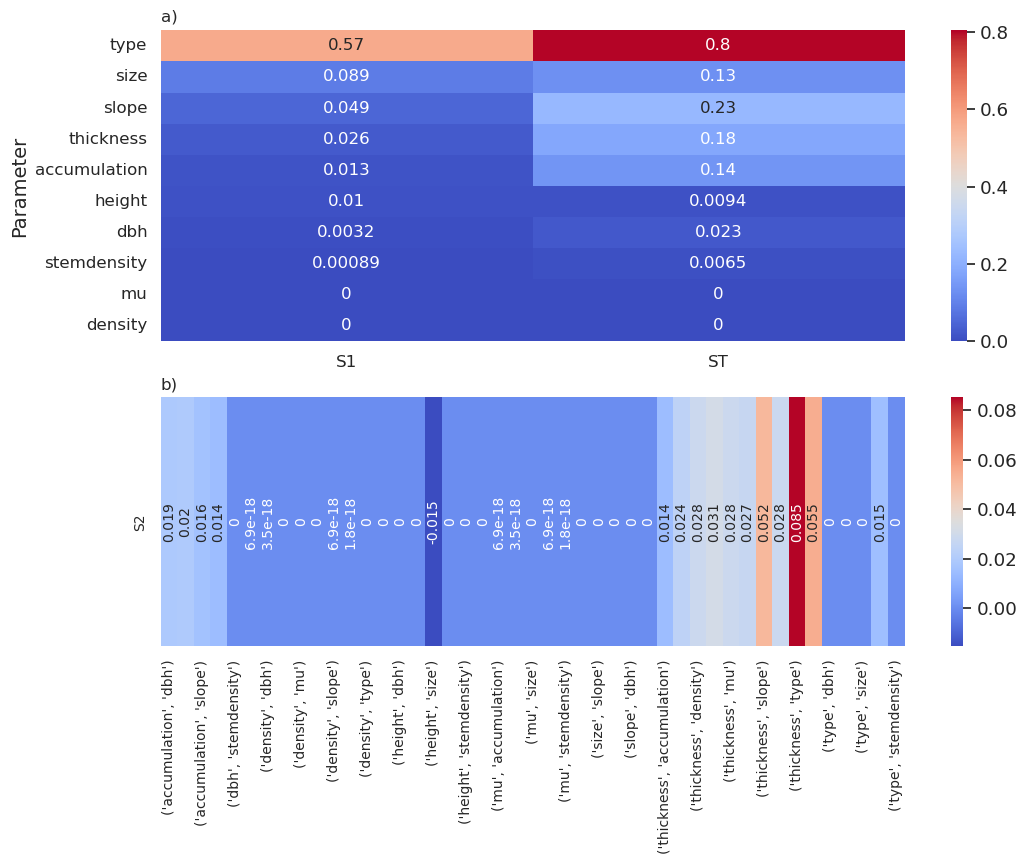

In [49]:
# Runout area in cells
res_n = analyze_sensitivity(df=df_combination, param_vals=param_values, problem_dict=problem, x_col="step", y_col="n_runout")

(22528, 10)
(22528,)
(22528,)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


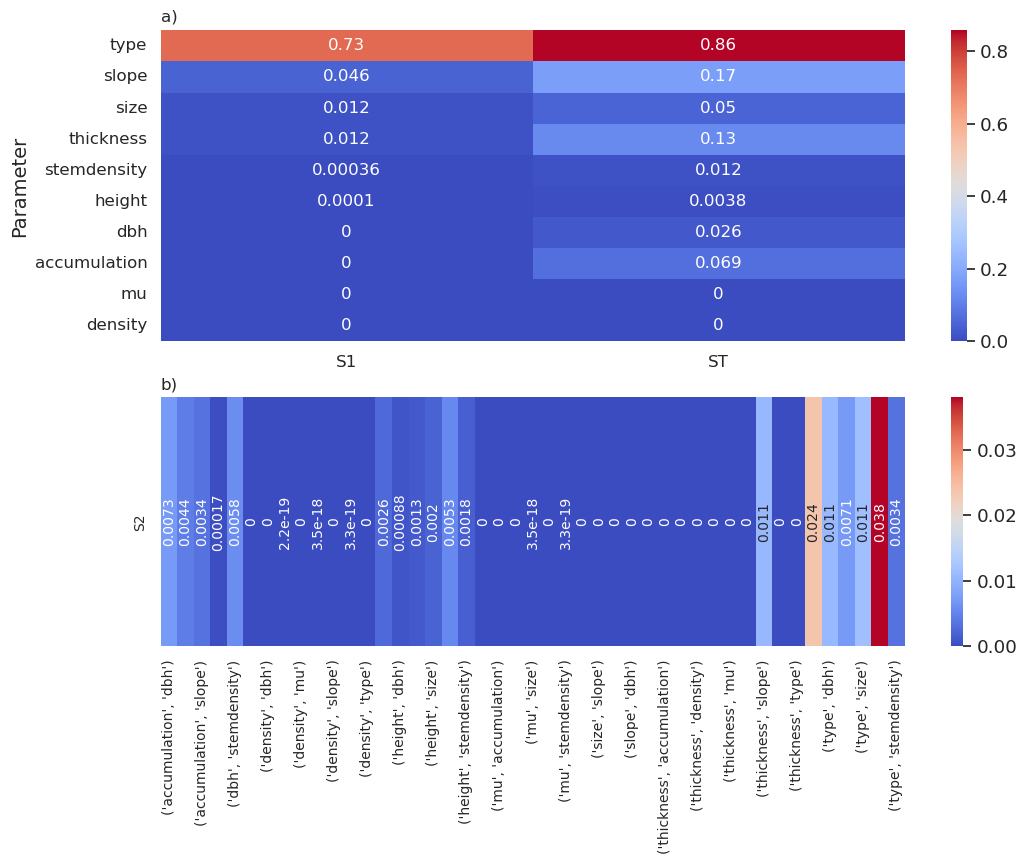

In [50]:
# Runout length in cells
res_w = analyze_sensitivity(df=df_combination, param_vals=param_values, problem_dict=problem, x_col="step", y_col="w")

(22528, 10)
(22528,)
(22528,)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


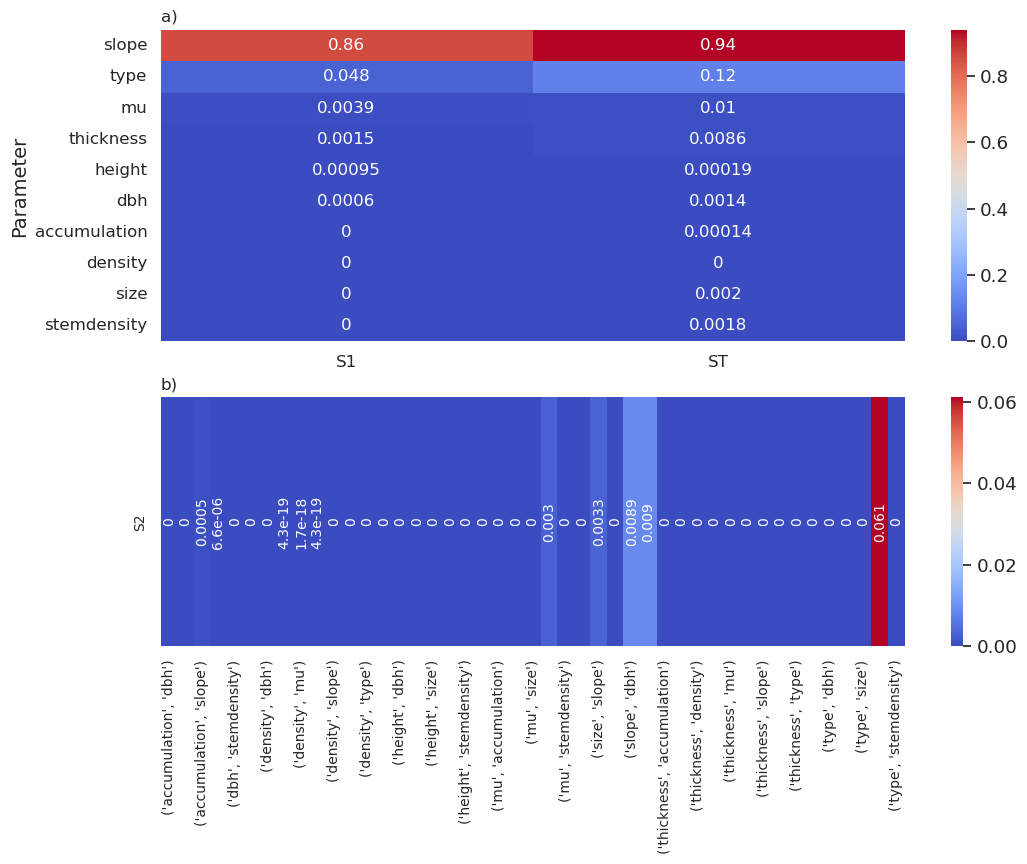

In [51]:
# Maximum of mean velocity
res_v = analyze_sensitivity(df=df_combination, param_vals=param_values, problem_dict=problem, x_col="step", y_col="v_max")

(22528, 10)
(22528,)
(22528,)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


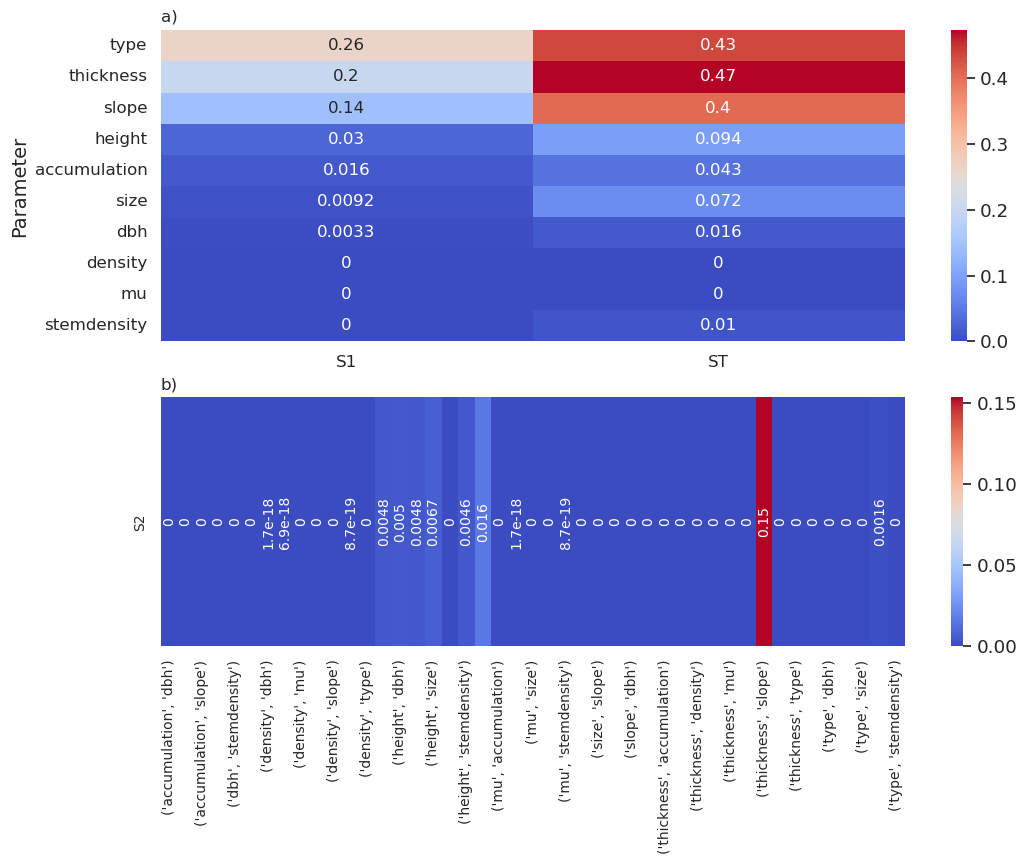

In [52]:
# Maximum of mean flow height
res_fh = analyze_sensitivity(df=df_combination, param_vals=param_values, problem_dict=problem, x_col="step", y_col="fh_max")

Merging and outputting the analysis results (supplementary material).

In [53]:
res_s1s = [] 
res_s1 = res_n[0]
res_s1["outcome"] = "runout_area"
res_s1s.append(pd.melt(res_s1, id_vars=["index","outcome"], value_vars=["S1","S1_conf","ST","ST_conf"]))

res_s1 = res_v[0]
res_s1["outcome"] = "MAX(v_mean)"
res_s1s.append(pd.melt(res_s1, id_vars=["index","outcome"], value_vars=["S1","S1_conf","ST","ST_conf"]))


res_s1 = res_fh[0]
res_s1["outcome"] = "MAX(fh_mean)"
res_s1s.append(pd.melt(res_s1, id_vars=["index","outcome"], value_vars=["S1","S1_conf","ST","ST_conf"]))

res_s1_merged = pd.concat(res_s1s)
res_s1_merged = res_s1_merged[res_s1_merged["variable"].isin(["S1","ST"])]
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(res_s1_merged.pivot(index=["index"], columns=["outcome","variable"],values="value"))
print(res_s1_merged.pivot(index=["index"], columns=["outcome","variable"],values="value").to_latex(bold_rows=True,float_format="{:.3f}".format))

outcome      runout_area        MAX(v_mean)            MAX(fh_mean)       
variable              S1     ST          S1         ST           S1     ST
index                                                                     
accumulation   1.341e-02  0.141   0.000e+00  1.403e-04        0.016  0.043
dbh            3.224e-03  0.023   5.977e-04  1.397e-03        0.003  0.016
density        0.000e+00  0.000   0.000e+00  0.000e+00        0.000  0.000
height         1.030e-02  0.009   9.531e-04  1.876e-04        0.030  0.094
mu             0.000e+00  0.000   3.913e-03  1.024e-02        0.000  0.000
size           8.942e-02  0.131   0.000e+00  2.044e-03        0.009  0.072
slope          4.937e-02  0.226   8.552e-01  9.377e-01        0.142  0.404
stemdensity    8.853e-04  0.007   0.000e+00  1.752e-03        0.000  0.010
thickness      2.555e-02  0.180   1.494e-03  8.585e-03        0.200  0.472
type           5.663e-01  0.805   4.820e-02  1.162e-01        0.262  0.434

\begin{tabular}{lrrrrrr}
\toprule
outcome & \multicolumn{2}{r}{runout_area} & \multicolumn{2}{r}{MAX(v_mean)} & \multicolumn{2}{r}{MAX(fh_mean)} \\
variable & S1 & ST & S1 & ST & S1 & ST \\
index &  &  &  &  &  &  \\
\midrule
\textbf{accumulation} & 0.013 & 0.141 & 0.000 & 0.000 & 0.016 & 0.043 \\
\textbf{dbh} & 0.003 & 0.023 & 0.001 & 0.001 & 0.003 & 0.016 \\
\textbf{density} & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\textbf{height} & 0.010 & 0.009 & 0.001 & 0.000 & 0.030 & 0.094 \\
\textbf{mu} & 0.000 & 0.000 & 0.004 & 0.010 & 0.000 & 0.000 \\
\textbf{size} & 0.089 & 0.131 & 0.000 & 0.002 & 0.009 & 0.072 \\
\textbf{slope} & 0.049 & 0.226 & 0.855 & 0.938 & 0.142 & 0.404 \\
\textbf{stemdensity} & 0.001 & 0.007 & 0.000 & 0.002 & 0.000 & 0.010 \\
\textbf{thickness} & 0.026 & 0.180 & 0.001 & 0.009 & 0.200 & 0.472 \\
\textbf{type} & 0.566 & 0.805 & 0.048 & 0.116 & 0.262 & 0.434 \\
\bottomrule
\end{tabular}



In [54]:
res_s2s = [] 
res_s2 = res_n[1]
res_s2["outcome"] = "runout_area"
res_s2s.append(pd.melt(res_s2, id_vars=["index","outcome"], value_vars=["S2","S2_conf"]))

res_s2 = res_v[1]
res_s2["outcome"] = "MAX(v_mean)"
res_s2s.append(pd.melt(res_s2, id_vars=["index","outcome"], value_vars=["S2","S2_conf"]))

res_s2 = res_fh[1]
res_s2["outcome"] = "MAX(fh_mean)"
res_s2s.append(pd.melt(res_s2, id_vars=["index","outcome"], value_vars=["S2","S2_conf"]))

res_s2_merged = pd.concat(res_s2s)
res_s2_merged = res_s2_merged[res_s2_merged["variable"].isin(["S2"])]
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(res_s2_merged.pivot(index=["index"], columns=["outcome","variable"],values="value"))
print(res_s2_merged.pivot(index=["index"], columns=["outcome","variable"],values="value").to_latex(bold_rows=True,float_format="{:.3f}".format))

outcome                     runout_area MAX(v_mean) MAX(fh_mean)
variable                             S2          S2           S2
index                                                           
(accumulation, dbh)           1.899e-02   0.000e+00    0.000e+00
(accumulation, size)          1.963e-02   0.000e+00    0.000e+00
(accumulation, slope)         1.599e-02   4.960e-04    0.000e+00
(accumulation, stemdensity)   1.431e-02   6.646e-06    0.000e+00
(dbh, stemdensity)            0.000e+00   0.000e+00    0.000e+00
(density, accumulation)       6.939e-18   0.000e+00    0.000e+00
(density, dbh)                3.469e-18   0.000e+00    1.735e-18
(density, height)             0.000e+00   4.337e-19    6.939e-18
(density, mu)                 0.000e+00   1.735e-18    0.000e+00
(density, size)               0.000e+00   4.337e-19    0.000e+00
(density, slope)              6.939e-18   0.000e+00    0.000e+00
(density, stemdensity)        1.843e-18   0.000e+00    8.674e-19
(density, type)               0.000e+00   0.000e+00    0.000e+00
(height, accumulation)        0.000e+00   0.000e+00    4.776e-03
(height, dbh)                 0.000e+00   0.000e+00    4.995e-03
(height, mu)                  0.000e+00   0.000e+00    4.764e-03
(height, size)               -1.544e-02   0.000e+00    6.698e-03
(height, slope)               0.000e+00   0.000e+00    0.000e+00
(height, stemdensity)         0.000e+00   0.000e+00    4.612e-03
(height, type)                0.000e+00   0.000e+00    1.592e-02
(mu, accumulation)            6.939e-18   0.000e+00    0.000e+00
(mu, dbh)                     3.469e-18   0.000e+00    1.735e-18
(mu, size)                    0.000e+00   0.000e+00    0.000e+00
(mu, slope)                   6.939e-18   2.997e-03    0.000e+00
(mu, stemdensity)             1.843e-18   0.000e+00    8.674e-19
(size, dbh)                   0.000e+00   0.000e+00    0.000e+00
(size, slope)                 0.000e+00   3.299e-03    0.000e+00
(size, stemdensity)           0.000e+00   0.000e+00    0.000e+00
(slope, dbh)                  0.000e+00   8.865e-03    0.000e+00
(slope, stemdensity)          0.000e+00   8.986e-03    0.000e+00
(thickness, accumulation)     1.426e-02   0.000e+00    0.000e+00
(thickness, dbh)              2.411e-02   0.000e+00    0.000e+00
(thickness, density)          2.830e-02   0.000e+00    0.000e+00
(thickness, height)           3.109e-02   0.000e+00    0.000e+00
(thickness, mu)               2.830e-02   0.000e+00    0.000e+00
(thickness, size)             2.668e-02   0.000e+00    0.000e+00
(thickness, slope)            5.158e-02   0.000e+00    1.536e-01
(thickness, stemdensity)      2.777e-02   0.000e+00    0.000e+00
(thickness, type)             8.509e-02   0.000e+00    0.000e+00
(type, accumulation)          5.463e-02   0.000e+00    0.000e+00
(type, dbh)                   0.000e+00   0.000e+00    0.000e+00
(type, mu)                    0.000e+00   0.000e+00    0.000e+00
(type, size)                  0.000e+00   0.000e+00    0.000e+00
(type, slope)                 1.505e-02   6.101e-02    1.580e-03
(type, stemdensity)           0.000e+00   0.000e+00    0.000e+00

\begin{tabular}{lrrr}
\toprule
outcome & runout_area & MAX(v_mean) & MAX(fh_mean) \\
variable & S2 & S2 & S2 \\
index &  &  &  \\
\midrule
\textbf{('accumulation', 'dbh')} & 0.019 & 0.000 & 0.000 \\
\textbf{('accumulation', 'size')} & 0.020 & 0.000 & 0.000 \\
\textbf{('accumulation', 'slope')} & 0.016 & 0.000 & 0.000 \\
\textbf{('accumulation', 'stemdensity')} & 0.014 & 0.000 & 0.000 \\
\textbf{('dbh', 'stemdensity')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'accumulation')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'dbh')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'height')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'mu')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'size')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'slope')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'stemdensity')} & 0.000 & 0.000 & 0.000 \\
\textbf{('density', 'type')} & 0.000 & 0.000 & 0.000 \\
\textbf{('height', 'accumulation')} & 0.000 & 0.000 & 0.005 \\
\textbf{('height', 'dbh')

### Sensitivity Analysis for HDF in Forest with variable Friction

Reading input data for simulations for hillslope debris flows in forest with variable Friction.

In [55]:
sobol_parameters_path = os.path.join(input_base_path,"sensitivity_forest","sensitivity_param_values_variable.txt")

combination_path = os.path.join(input_base_path,"sensitivity_forest","sim_stats_merged.csv")

In [56]:
df_params = pd.read_csv(sobol_parameters_path,sep=" ",names= ["thickness", "density", "height", "type", "mu", "accumulation"])
df_params.head()

thickness      density    height  type   mu  accumulation
0   0.541968  1374.077931  0.997335   2.0  0.0           1.0
1   1.339725  1374.077931  0.997335   2.0  0.0           1.0
2   0.541968  1603.601977  0.997335   2.0  0.0           1.0
3   0.541968  1374.077931  1.472119   2.0  0.0           1.0
4   0.541968  1374.077931  0.997335   2.0  0.0           1.0

In [57]:
df_combination = pd.read_csv(combination_path,sep=",")

print(len(df_combination))

315392


In [58]:
len(df_combination["slide_id"].unique())

22

In [59]:
num_sim = len(df_params)
num_sim

14336

In [60]:
df_combination["slide_id"] = df_combination["slide_id"].astype("int32")
df_combination["step"] = df_combination["step"].astype("int32")
df_combination = df_combination.sort_values(["step","slide_id"])

df_combination.head()


slide_id  step  x_min  x_max  y_min  y_max    w    h  max_spread  \
0          1     0      1    131     50    126  130   76          16   
6          2     0     35    126     99    129   91   30           9   
20         3     0     71    120      1    115   49  114          40   
15         4     0    100    148    100    215   48  115          36   
10         5     0     98    142    100    210   44  110          52   

    n_runout      v_max     v_mean    fh_max   fh_mean  
0        328  13.566154   9.863057  0.490877  0.219692  
6        345  13.999794  10.953051  0.540186  0.123372  
20       615  12.085999   7.885766  0.611522  0.211328  
15       329  13.243094   8.902625  0.626528  0.181704  
10       257  12.790019   7.995458  0.637126  0.182472

Problem definition.

In [61]:
problem = {
    "num_vars": 6,
    "names": ["thickness", "density", "height", "type", "mu", "accumulation"],
    "bounds": [[0.2, 2], # slide thickness
               [1000, 2000], # moving mass density
               [0.5, 2], #maximum flow height
               [0,3], # hdf type
               [0,1], # forest mu
               [0,1] # forest debris accumulation
               ]
}

# Read parameter values from simulation input
param_values = np.loadtxt(sobol_parameters_path) 



Function for running the Sobol analysis with respect to a specific target variable for multiple plots and aggregating them.

In [62]:
def analyze_sensitivity_aggregated(df, param_vals, problem_dict, y_col="n_runout"):

    df_comb_transposed = df.pivot(index=["step"], columns="slide_id", values=[y_col])
    x = df_combination["slide_id"].unique()
    y = df_comb_transposed.to_numpy().T


    sp = ProblemSpec(problem)
    sp.set_results(y.T)
    sp.analyze_sobol(print_to_console=False,seed=100000)



    y_vars = df_comb_transposed.apply(lambda x: np.var(x),axis=0)
    y_vars_sum = np.sum(y_vars)
    y_vars_sum
    len(y_vars)
    
    Su_agg = {}
    
    su = {"S1","ST"}
    
    for u in su:
        sus = np.array([sp.analysis[k][u] for k in sp.analysis])
        susc  = np.array([sp.analysis[k][u+"_conf"] for k in sp.analysis])
        for i in range(len(sp["names"])):
            name = sp["names"][i]        
            if name in Su_agg:
                sus_agg = Su_agg[name]
            else:
                sus_agg = {"param":name}
        
            
            sut = sus[:,i]*y_vars
            sui_agg = np.sum(sut)/y_vars_sum
            sus_agg[u+"_uncorrected"] = sui_agg
    
            positive_or_plausible_zero = True
            sut = np.copy(sus[:,i])
            sutc = np.copy(susc[:,i])
            for j in range(len(sut)):
                test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
                positive_or_plausible_zero = positive_or_plausible_zero and test
                if sut[j]<0 and test:
                    sut[j]=0
                elif sut[j]<0:
                    print(j,sut[j],sutc[j])
            sus_agg[u+"_check"] = positive_or_plausible_zero
    
            sut = sut*y_vars
            sui_agg = np.sum(sut)/y_vars_sum
            sus_agg[u] = sui_agg
    
            Su_agg[name] = sus_agg      
        
    
    u = "S2"
    names = sp["names"]
    combs = list(itertools.combinations(names, 2))
    for cmb in combs:
        name = " ".join(cmb)
        i0 = names.index(cmb[0])
        i1 = names.index(cmb[1])
    
        if name in Su_agg:
            s2_agg = Su_agg[name]
        else:
            s2_agg = {"param":name}
        
        sus = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]
    
        sut = sus*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        s2_agg[u+"_uncorrected"] = sui_agg
    
        positive_or_plausible_zero = True
        sut = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]
        sutc = [sp.analysis[ky][u+"_conf"][i0][i1] for ky in sp.analysis.keys()]    
        for j in range(len(sut)):
            test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
            positive_or_plausible_zero = positive_or_plausible_zero and test
            if sut[j]<0 and test:
                sut[j]=0
            elif sut[j]<0:
                print(j,sut[j],sutc[j])
                
        
        s2_agg[u+"_check"] = positive_or_plausible_zero
    
        sut = sut*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        s2_agg[u] = sui_agg
    
    
        Su_agg[name] = s2_agg   

    Su_agg_df = pd.DataFrame(Su_agg.values())
    Su_agg_df["param"] = Su_agg_df["param"].apply(lambda x: x.replace("_mean"," "))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])
    # fig.suptitle("Sensitivity Analysis")
    
    plt.subplots_adjust(right = 1.1)
    
    font_size_default = plt.rcParams.get("font.size")
    font_size = 12
    plt.rcParams.update({"font.size": font_size})
    
    cmap = "coolwarm"

    mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
    pvt = mlt.pivot(index="param", columns="variable",values="value")
    pvt = pvt.sort_values(by=["S1"],ascending=False)
    g1 = sns.heatmap(pvt, annot=True, ax=ax1, cmap = cmap)
    g1.set_ylabel("Parameter",fontsize=font_size+2)
    g1.set_xlabel("",fontsize=font_size)
    ax1.set_title("a)", fontfamily='sans-serif', loc='left', fontsize='medium')
    ax1.tick_params(labelsize=font_size)
        
    mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S2"]))], id_vars=["param"], value_vars=["S2"])
    pvt = mlt.pivot(index="param", columns="variable",values="value")
    g2 = sns.heatmap(pvt, annot=True, ax=ax2, cmap = cmap)
    g2.set(xlabel="",ylabel="")
    ax2.tick_params(labelsize=10)
    ax2.set_title("b)", fontfamily='sans-serif', loc='left', fontsize='medium')

# pvt2 = mlt.pivot(index="param", columns="variable",values="value")
# idx = pvt.index.array.tolist()
# pvt2.sort_index( key=lambda x: [idx.index(y) for y in x.array.tolist() ], inplace=True)
    
    plt.rcParams.update({"font.size": font_size_default})

    plt.show(fig)

    return Su_agg_df


Perform analysis for different target variables.

/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


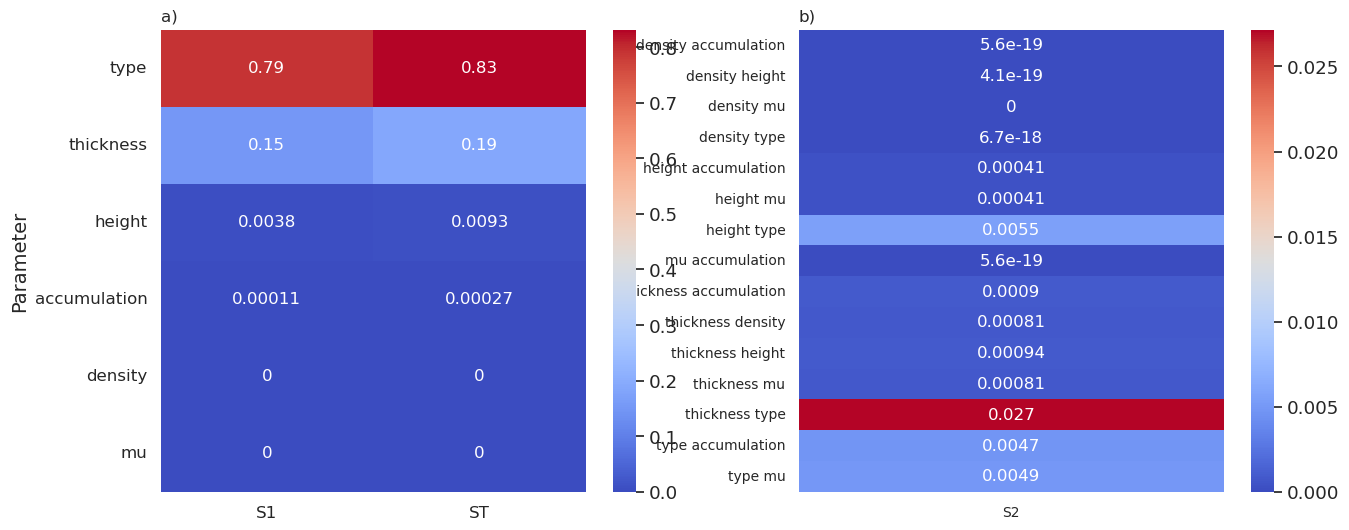

In [63]:
# Runout area in cells
res_n = analyze_sensitivity_aggregated(df_combination, param_values, problem, y_col="n_runout")

/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


5 -0.004194432815871608 0.0037269097217228577
19 -0.021720290558323155 0.016632285727311905
19 -0.020309515993032556 0.0168312466733166
19 -0.021897235464378877 0.016879156276042546
19 -0.020910453590448845 0.01659735492489179
4 -1.1102230246251565e-16 1.0095607285855256e-16


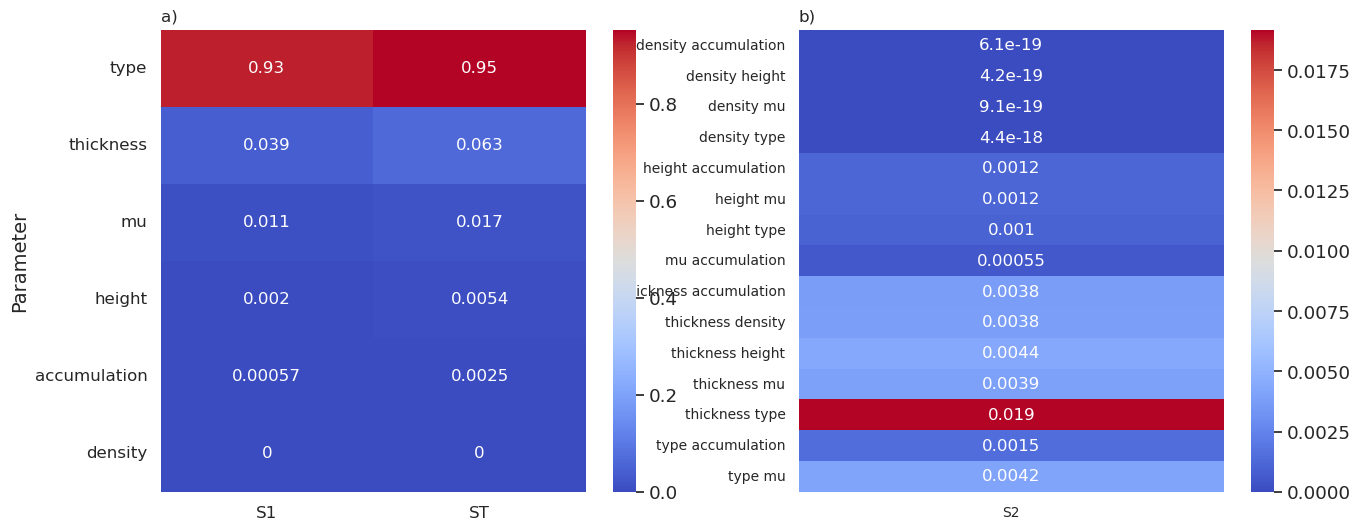

In [64]:
# Maximum of mean velocity
res_v = analyze_sensitivity_aggregated(df_combination, param_values, problem, y_col="v_max")

/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


1 -8.532973232642648e-05 7.960402654787054e-05
7 -1.1102230246251565e-16 1.101975842360567e-16
9 -3.1509625637859973e-18 2.7291251261740964e-18
10 -2.3445871979999033e-18 2.212441916605676e-18
9 -3.1509625637859973e-18 2.7291251261740964e-18
10 -2.3445871979999033e-18 2.212441916605676e-18


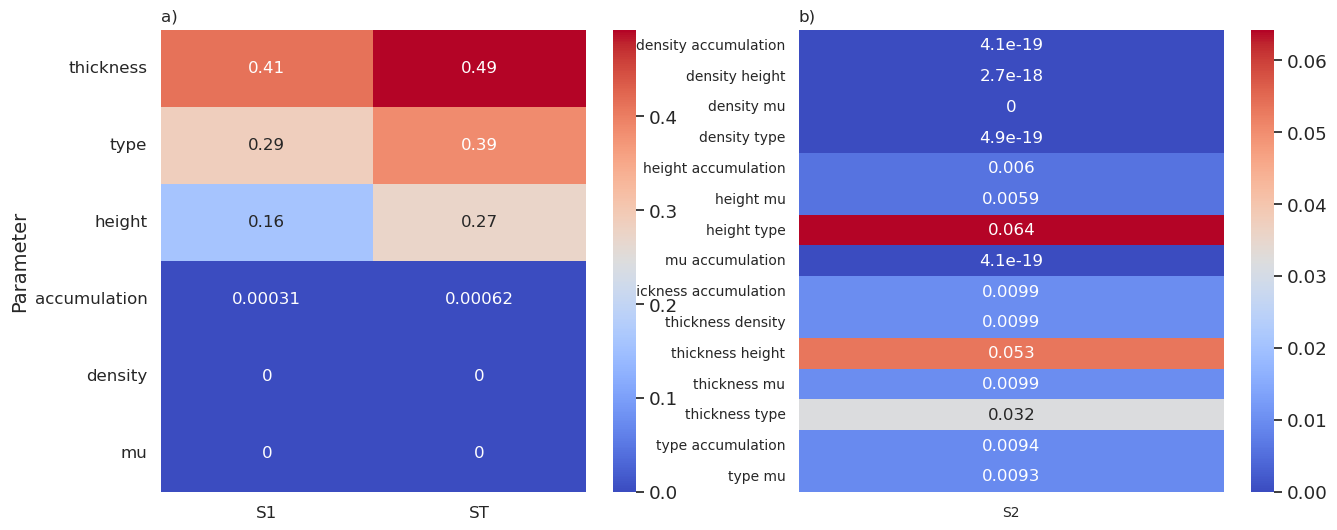

In [65]:
# Maximum of mean flow height
res_fh = analyze_sensitivity_aggregated(df_combination, param_values, problem, y_col="fh_max")

Merging and outputting the analysis results (supplementary material).

In [66]:
res_s1s = [] 
res_s1 = pd.melt(res_n.loc[np.invert(np.isnan(res_n["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
res_s1["outcome"] = "runout_area"
res_s1s.append(res_s1)

res_s1 = pd.melt(res_v.loc[np.invert(np.isnan(res_v["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
res_s1["outcome"] = "MAX(v_mean)"
res_s1s.append(res_s1)

res_s1 = pd.melt(res_fh.loc[np.invert(np.isnan(res_fh["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
res_s1["outcome"] = "MAX(fh_mean)"
res_s1s.append(res_s1)

res_s1_merged = pd.concat(res_s1s)
res_s1_merged = res_s1_merged[res_s1_merged["variable"].isin(["S1","ST"])]
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(res_s1_merged.pivot(index=["param"], columns=["outcome","variable"],values="value"))
print(res_s1_merged.pivot(index=["param"], columns=["outcome","variable"],values="value").to_latex(bold_rows=True,float_format="{:.3f}".format))

outcome      runout_area            MAX(v_mean)        MAX(fh_mean)           
variable              S1         ST          S1     ST           S1         ST
param                                                                         
accumulation   1.113e-04  2.678e-04   5.696e-04  0.003    3.054e-04  6.249e-04
density        0.000e+00  0.000e+00   0.000e+00  0.000    0.000e+00  0.000e+00
height         3.806e-03  9.316e-03   2.040e-03  0.005    1.591e-01  2.727e-01
mu             0.000e+00  0.000e+00   1.061e-02  0.017    0.000e+00  0.000e+00
thickness      1.523e-01  1.853e-01   3.881e-02  0.063    4.117e-01  4.921e-01
type           7.890e-01  8.310e-01   9.265e-01  0.952    2.882e-01  3.850e-01

\begin{tabular}{lrrrrrr}
\toprule
outcome & \multicolumn{2}{r}{runout_area} & \multicolumn{2}{r}{MAX(v_mean)} & \multicolumn{2}{r}{MAX(fh_mean)} \\
variable & S1 & ST & S1 & ST & S1 & ST \\
param &  &  &  &  &  &  \\
\midrule
\textbf{accumulation} & 0.000 & 0.000 & 0.001 & 0.003 & 0.000 & 0.001 \\
\textbf{density} & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\textbf{height} & 0.004 & 0.009 & 0.002 & 0.005 & 0.159 & 0.273 \\
\textbf{mu} & 0.000 & 0.000 & 0.011 & 0.017 & 0.000 & 0.000 \\
\textbf{thickness} & 0.152 & 0.185 & 0.039 & 0.063 & 0.412 & 0.492 \\
\textbf{type} & 0.789 & 0.831 & 0.927 & 0.952 & 0.288 & 0.385 \\
\bottomrule
\end{tabular}



In [67]:
res_s2s = [] 
res_s2 = pd.melt(res_n.loc[np.invert(np.isnan(res_n["S2"]))], id_vars=["param"], value_vars=["S2"])
res_s2["outcome"] = "runout_area"
res_s2s.append(res_s2)

res_s2 = pd.melt(res_v.loc[np.invert(np.isnan(res_v["S2"]))], id_vars=["param"], value_vars=["S2"])
res_s2["outcome"] = "MAX(v_mean)"
res_s2s.append(res_s2)

res_s2 = pd.melt(res_fh.loc[np.invert(np.isnan(res_fh["S2"]))], id_vars=["param"], value_vars=["S2"])
res_s2["outcome"] = "MAX(fh_mean)"
res_s2s.append(res_s2)

res_s2_merged = pd.concat(res_s2s)

res_s2_merged = res_s2_merged[res_s2_merged["variable"].isin(["S2"])]
with pd.option_context("display.max_rows", 200, "display.max_columns", 40,"display.precision", 3):
    display(res_s2_merged.pivot(index=["param"], columns=["outcome","variable"],values="value"))
print(res_s2_merged.pivot(index=["param"], columns=["outcome","variable"],values="value").to_latex(bold_rows=True,float_format="{:.3f}".format))


outcome                runout_area MAX(v_mean) MAX(fh_mean)
variable                        S2          S2           S2
param                                                      
density accumulation     5.590e-19   6.113e-19    4.051e-19
density height           4.102e-19   4.218e-19    2.697e-18
density mu               0.000e+00   9.082e-19    0.000e+00
density type             6.703e-18   4.408e-18    4.883e-19
height accumulation      4.061e-04   1.153e-03    5.958e-03
height mu                4.143e-04   1.161e-03    5.907e-03
height type              5.525e-03   1.045e-03    6.421e-02
mu accumulation          5.590e-19   5.518e-04    4.051e-19
thickness accumulation   9.048e-04   3.812e-03    9.931e-03
thickness density        8.058e-04   3.827e-03    9.881e-03
thickness height         9.370e-04   4.358e-03    5.319e-02
thickness mu             8.058e-04   3.949e-03    9.881e-03
thickness type           2.716e-02   1.917e-02    3.163e-02
type accumulation        4.701e-03   1.493e-03    9.380e-03
type mu                  4.946e-03   4.167e-03    9.297e-03

\begin{tabular}{lrrr}
\toprule
outcome & runout_area & MAX(v_mean) & MAX(fh_mean) \\
variable & S2 & S2 & S2 \\
param &  &  &  \\
\midrule
\textbf{density accumulation} & 0.000 & 0.000 & 0.000 \\
\textbf{density height} & 0.000 & 0.000 & 0.000 \\
\textbf{density mu} & 0.000 & 0.000 & 0.000 \\
\textbf{density type} & 0.000 & 0.000 & 0.000 \\
\textbf{height accumulation} & 0.000 & 0.001 & 0.006 \\
\textbf{height mu} & 0.000 & 0.001 & 0.006 \\
\textbf{height type} & 0.006 & 0.001 & 0.064 \\
\textbf{mu accumulation} & 0.000 & 0.001 & 0.000 \\
\textbf{thickness accumulation} & 0.001 & 0.004 & 0.010 \\
\textbf{thickness density} & 0.001 & 0.004 & 0.010 \\
\textbf{thickness height} & 0.001 & 0.004 & 0.053 \\
\textbf{thickness mu} & 0.001 & 0.004 & 0.010 \\
\textbf{thickness type} & 0.027 & 0.019 & 0.032 \\
\textbf{type accumulation} & 0.005 & 0.001 & 0.009 \\
\textbf{type mu} & 0.005 & 0.004 & 0.009 \\
\bottomrule
\end{tabular}

